# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=a50174e677a4bebe5fc6fceec4acf09ef5db611323294adc9305f83ea3888795
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [6]:
!pip install kanjize

In [7]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [8]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [9]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]
    # 数値変換し5足す
    tmp = int(tmp)
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

<ipython-input-9-766871c38253>:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

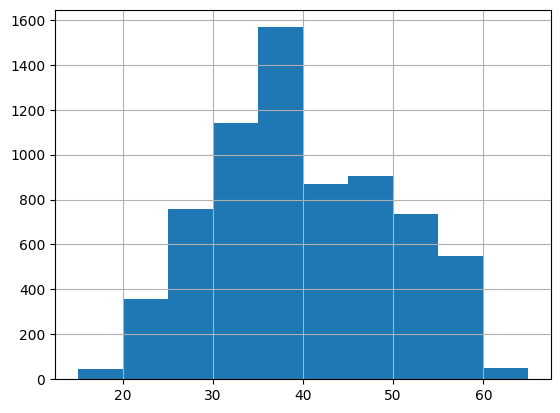

In [10]:
all_df["Age"].hist()

In [11]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損を埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

In [12]:
# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [13]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


In [14]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

<Axes: >

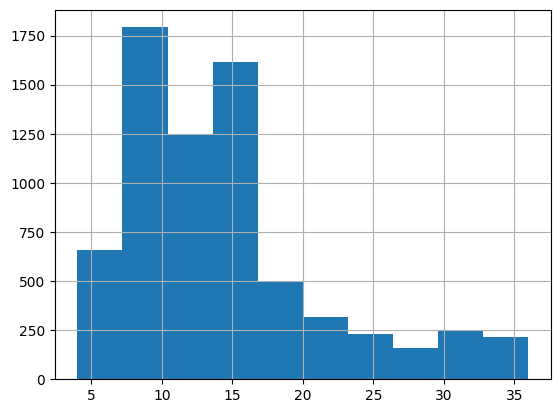

In [15]:
# 分布の確認
all_df["DurationOfPitch"].hist()

In [16]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択のためホットエンコードにする
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [17]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"

  else:
    all_df.loc[i,"Gender"] = "Female"

In [18]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [19]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [20]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

In [21]:
# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

In [22]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [23]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

In [24]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [25]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

In [26]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [27]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [28]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

<Axes: >

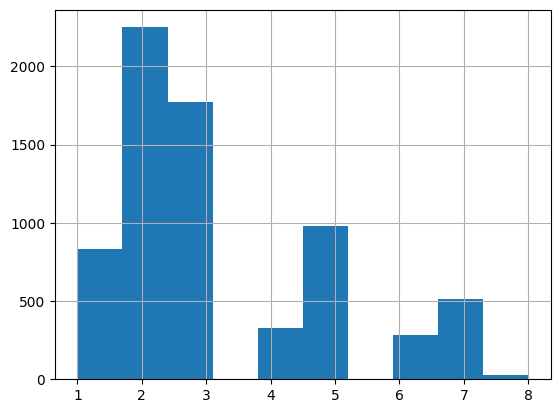

In [29]:
# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [30]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

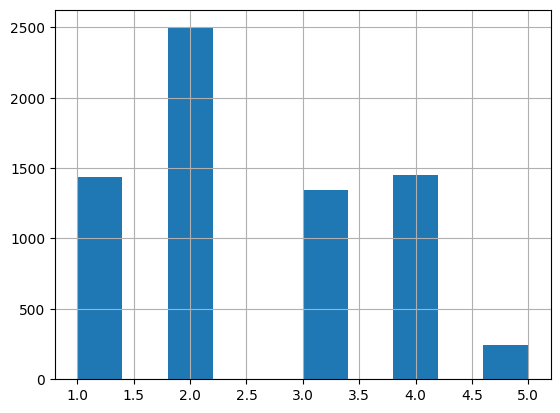

In [31]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [32]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [33]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [34]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

In [35]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


In [36]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

<Axes: >

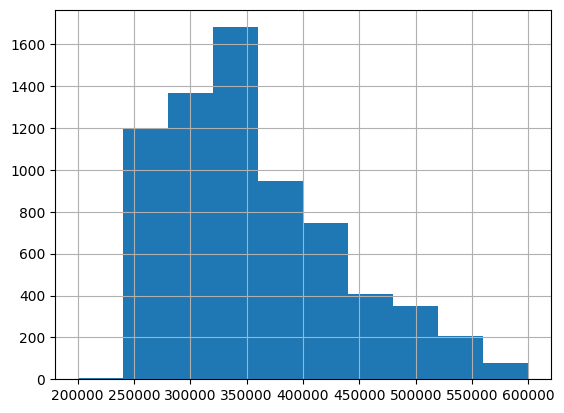

In [37]:
# 分布の確認
all_df["MonthlyIncome"].hist()

In [38]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [39]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [40]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [41]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [42]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


# ラベルエンコード



In [46]:
# 「Dsignation」をラベルエンコード
all_df["Designation_LE"] = 1
all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 1

In [47]:
# 「Occupation」をラベルエンコード
all_df["Occupation_LE"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 2
all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 1

In [48]:
# 「CarHolder」をラベルエンコード
all_df["CarHolder_LE"] = all_df["CarHolder"] + 1

In [49]:
# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=2

In [50]:
# 「ProductPitched」をラベルエンコード
all_df["ProductPitched_LE"] = 1
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=5
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=4
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=3
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=2
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=1

In [51]:
# 「Married」をラベルエンコード
all_df["Married_LE"] = 1
all_df.loc[all_df["Married"]=="Married","Married_LE"]=3
all_df.loc[all_df["Married"]=="Divorce","Married_LE"]=2
all_df.loc[all_df["Married"]=="Single","Married_LE"]=1

In [52]:
# 「TypeofContact」をラベルエンコード
all_df["TypeofContact_LE"] = 1
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact_LE"]=2
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact_LE"]=1

In [55]:
# エンコード前のラベルを抹消する
all_df = all_df.drop("Designation", axis=1)
all_df = all_df.drop("Occupation", axis=1)
all_df = all_df.drop("Gender", axis=1)
all_df = all_df.drop("ProductPitched", axis=1)
all_df = all_df.drop("Married", axis=1)
all_df = all_df.drop("CarHolder", axis=1)
all_df = all_df.drop("TypeofContact", axis=1)

In [56]:
# 検討の結果、重要度が低いものを抹消する
all_df = all_df.drop("Occupation_LE", axis=1)
all_df = all_df.drop("NumberOfFollowups", axis=1)
all_df = all_df.drop("PreferredPropertyStar", axis=1)
all_df = all_df.drop("Gender_LE", axis=1)

In [60]:
!pip install seaborn

In [77]:
# 相関係数
all_df_corr = all_df.corr()
# 上三角行列だけ抽出
upper = tmp.where(np.triu(np.ones(tmp.shape), k=1).astype(bool))
# 0.6以上の相関ペアを抽出
high_corr = [(col, row) for col in upper.columns for row in upper.index if abs(upper.loc[row, col]) > 0.6]
print("相関が高すぎる特徴ペア:", high_corr)

相関が高すぎる特徴ペア: []


<Axes: >

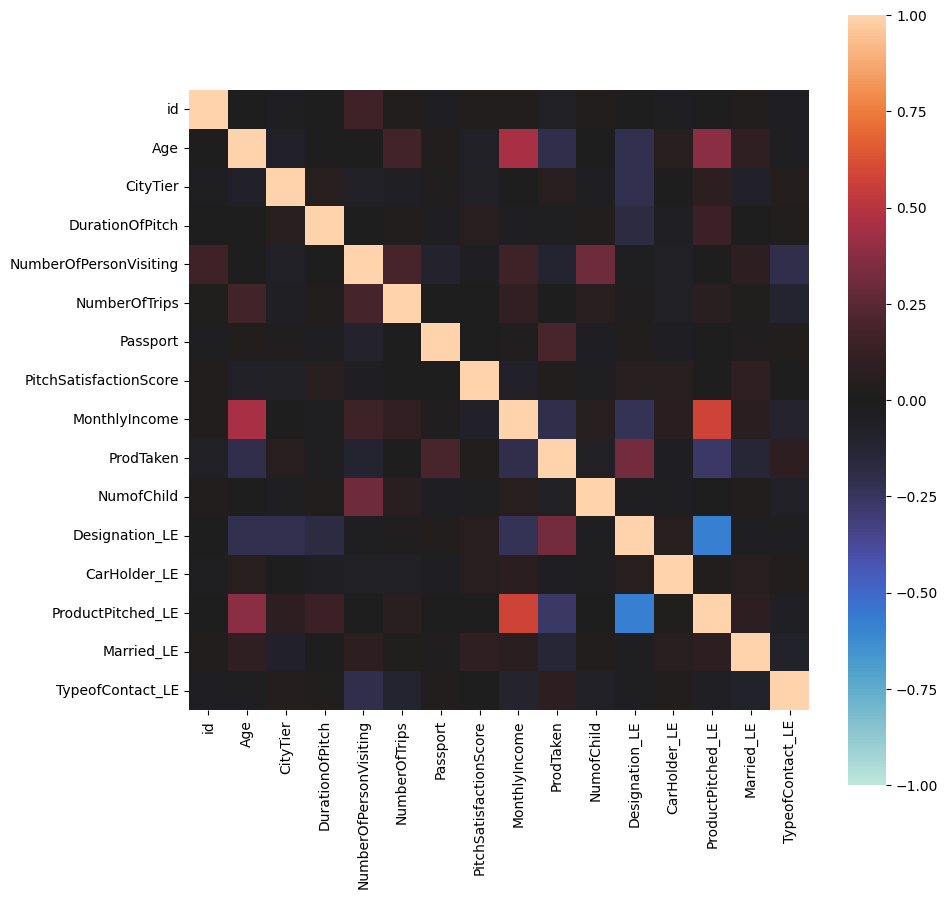

In [63]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(all_df.corr(), square=True, vmax=1, vmin=-1, center=0)

# 交差特徴量を追加する

In [80]:
# 1.「Age」x「DurationOfPitch」
all_df["Age_X_Duration"] = all_df["Age"] * all_df["DurationOfPitch"]
# 2.「都市の富裕度」x「商品グレード」
all_df["City_X_Product"] = all_df["CityTier"] * all_df["ProductPitched_LE"]
# 3.「連絡手段」x「顧客満足度」
all_df["Contact_X_Satisfaction"] = all_df["TypeofContact_LE"] * all_df["PitchSatisfactionScore"]
# 4.「婚姻歴」x「子供の数」
all_df["Married_X_Children"] = all_df["Married_LE"] * all_df["NumofChild"]
# 5.「同行者数」x「年齢」
all_df["Person_X_Age"] = all_df["NumberOfPersonVisiting"] * all_df["Age"]

In [85]:
# 生活余裕度 = 月収 ÷ (子供の数 + 1)
all_df["LivingAbility"] = all_df["MonthlyIncome"] / (all_df["NumofChild"] + 1)

In [86]:
# 顧客価値スコア = 顧客満足度 x 年間旅行数
all_df["CustomerValue"] = all_df["PitchSatisfactionScore"] * all_df["NumberOfTrips"]

In [87]:
# 営業効率
all_df["BusinessEfficiency"] = all_df["NumberOfTrips"] / all_df["DurationOfPitch"]

In [53]:
# # 1.「Age」×「MonthlyIncome」 (若年高収入 or 高齢低収入)
# all_df["Age_times_Income"] = all_df["Age"] * all_df["MonthlyIncome"]

# # 2.「MonthlyIncome」×「CityTier」 (地域と収入のミスマッチ度)
# all_df["Income_times_Tier"] = all_df["MonthlyIncome"] * all_df["CityTier"]

# # 3.「Designation」×「MonthlyIncome」 (実際の報酬と役職の一致度(過小/過大評価)
# all_df["Desig_times_Income"] = all_df["Designation_LE"] * all_df["MonthlyIncome"]

# # 4.「Occupation」×「CarHolder」 (経済属性の組み合わせ)
# all_df["Occu_times_Car"] = all_df["Occupation"] * all_df["CarHolder"]

# # 5.「Occupation」×「DurationOfPitch」 (ターゲット層ごとの営業効果の違い)
# all_df["Occu_times_DurPitch"] = all_df["Occupation_LE"] * all_df["DurationOfPitch"]

# # 6.「Gender」×「ProductPitched」 (商品嗜好の違いを反映)
# all_df["Gen_times_ProPitch"] = all_df["Gender_LE"] * all_df["ProductPitched_LE"]

# # 7.「Married」×「NumofChild」 (家庭環境の圧縮表現)
# all_df["Married_times_NumChild"] = all_df["Married_LE"] * all_df["NumofChild"]

# # 8.「Married」×「NumberOfFollowups」 (家族持ち層のフォロー行動の傾向分析)
# all_df["Married_times_NumFollow"] = all_df["Married_LE"] * all_df["NumberOfFollowups"]

# # 9.「NumberOfTrips」×「PreferredPropertyStar」 (旅行慣れ層の嗜好)
# all_df["NumTrips_times_PropStar"] = all_df["NumberOfTrips"] * all_df["PreferredPropertyStar"]

# # 10.「Passport」×「CitytTier」 (国際経験と居住地との関係性)
# all_df["Pass_times_Tier"] = all_df["Passport"] * all_df["CityTier"]

# # 11.「PrefferedPropertyStar」×「PitchSatisfactionScore」 (高級志向と満足度の関係性)
# all_df["PropStar_times_Satisfac"] = all_df["PreferredPropertyStar"] * all_df["PitchSatisfactionScore"]

# # 12.「ProductPitched」×「NumberOfTrips」 (リピーターに対する商品設計の効き方)
# all_df["ProPitch_times_Trip"] = all_df["ProductPitched"] * all_df["NumberOfTrips"]

# # 13.「TypeofContact」×「NumberOfFollowups」 (コンタクトチャネルの最適性分析)
# all_df["Contact_times_NumFollow"] = all_df["TypeofContact_LE"] * all_df["NumberOfFollowups"]

# # 14.「DurationPitched」×「PitchSatisfactionScore」 (営業時間と結果の相関分析)
# all_df["DurPitch_times_Satisfac"] = all_df["DurationOfPitch"] * all_df["PitchSatisfactionScore"]

# # 15.「TypeofContact」×「Age」 (高齢層に対する適切なチャネル分析)
# all_df["Contact_times_Age"] = all_df["TypeofContact_LE"] * all_df["Age"]

# # 16.(「MonthlyIncome」 ÷ 「CityTier」) × NumberOfTrips = 地域あたり可処分所得の旅行傾向
# all_df["Income_times_Tier_by_Trip"] = all_df["MonthlyIncome"] / all_df["CityTier"] * all_df["NumberOfTrips"]

# # 17.「Age」×「PitchSatisfactionScore」×「NumberOfFollowups」 = 長期的関係性の影響
# all_df["Age_times_Satisfac_times_NumFollow"] = all_df["Age"] * all_df["PitchSatisfactionScore"] * all_df["NumberOfFollowups"]

# # 18.「NumofChild」×「PreferredPropertyStar」 = 家族連れの高級志向傾向の抽出
# all_df["NumChild_times_PropStar"] = all_df["NumofChild"] * all_df["PreferredPropertyStar"]

In [88]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]
FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [89]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [90]:
# カラムを制限
all_df2 = all_df[FEATURES]

In [91]:
# from sklearn.preprocessing import OrdinalEncoder

# oe = OrdinalEncoder()
# all_df2[CATS] = oe.fit_transform(all_df2[CATS].values)

In [92]:
# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()
# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [112]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.8619308173567727, # 7回
    'num_leaves': 122, # 20回
    'bagging_fraction': 0.4085996823085894,
    'bagging_freq': 1,
    'lambda_l1': 9.987613722346149,
    'lambda_l2': 1.1163643318267733,
    'min_data_in_leaf': 51,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [124]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.848157	valid's auc: 0.840407
#########################
### Fold 2
#########################
[100]	train's auc: 0.86343	valid's auc: 0.798987
[200]	train's auc: 0.870465	valid's auc: 0.801688
[300]	train's auc: 0.87633	valid's auc: 0.802323
#########################
### Fold 3
#########################
[100]	train's auc: 0.852194	valid's auc: 0.827133
[200]	train's auc: 0.862656	valid's auc: 0.829192
CPU times: user 3.04 s, sys: 352 ms, total: 3.4 s
Wall time: 815 ms


In [125]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8211064515434855


In [100]:
# FOLD1
# lgb.plot_importance(models[0], figsize=(8,4), max_num_features=20, importance_type='gain')
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
feature = (importance0+importance1+importance2)/3
feature.sort_values("importance", ascending=False)

In [ ]:
!pip install shap

In [104]:
import shap
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()
# explainer = shap.TreeExplainer(model=models[0])

# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)

# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])

# ② SHAP値を計算
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))

# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

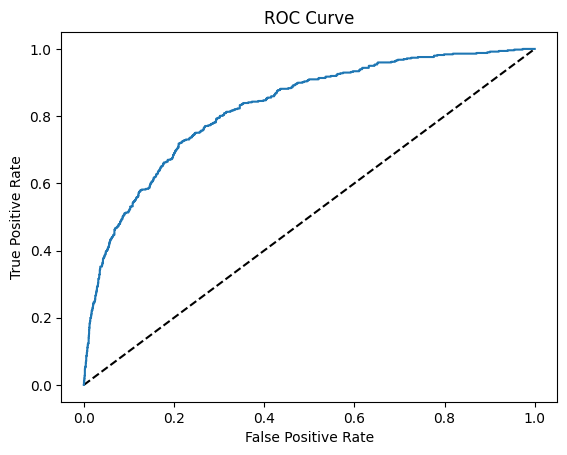

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [107]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.6 MB/s eta 0:00:00


In [109]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'regression',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      "learning_rate": 0.05,
      "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
      "num_leaves": trial.suggest_int("num_leaves", 2, 256),
      "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
      "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
      "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
      "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
      "min_data_in_leaf": trial.suggest_categorical("min_data_in_leaf", [5, 10, 25, 50, 100]),
      "max_bin": trial.suggest_int("max_bin", 100, 255),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)


  score = roc_auc_score(train[TARGET],oof_lgb)
  # mse = mean_squared_error(train[TARGET], oof_lgb)
  # rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-21 10:04:40,794] A new study created in memory with name: no-name-306fb11a-c991-418c-94f8-2069b468e142


#########################
### Fold 1
#########################
[100]	train's auc: 0.99997	valid's auc: 0.773562
#########################
### Fold 2
#########################
[100]	train's auc: 0.999885	valid's auc: 0.75123
#########################
### Fold 3
#########################
[100]	train's auc: 0.999923	valid's auc: 0.794158


[I 2025-05-21 10:04:44,107] Trial 0 finished with value: 0.7974682990994092 and parameters: {'feature_fraction': 0.656580782620815, 'num_leaves': 150, 'bagging_fraction': 0.772783151001444, 'bagging_freq': 2, 'lambda_l1': 4.320233244193046e-05, 'lambda_l2': 9.611682513740698e-05, 'min_data_in_leaf': 10, 'max_bin': 195}. Best is trial 0 with value: 0.7974682990994092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.891323	valid's auc: 0.827313
#########################
### Fold 2
#########################
[100]	train's auc: 0.90565	valid's auc: 0.788809
#########################
### Fold 3
#########################
[100]	train's auc: 0.892052	valid's auc: 0.828946


[I 2025-05-21 10:04:44,644] Trial 1 finished with value: 0.8205153380174093 and parameters: {'feature_fraction': 0.5786448970849705, 'num_leaves': 8, 'bagging_fraction': 0.8802760037796524, 'bagging_freq': 5, 'lambda_l1': 5.164590511258665e-07, 'lambda_l2': 0.0001603989091787954, 'min_data_in_leaf': 25, 'max_bin': 206}. Best is trial 1 with value: 0.8205153380174093.


#########################
### Fold 1
#########################
[100]	train's auc: 0.842975	valid's auc: 0.836235
[200]	train's auc: 0.853124	valid's auc: 0.838141
[300]	train's auc: 0.858151	valid's auc: 0.838074
#########################
### Fold 2
#########################
[100]	train's auc: 0.85976	valid's auc: 0.796256
[200]	train's auc: 0.867981	valid's auc: 0.797447
#########################
### Fold 3
#########################
[100]	train's auc: 0.845973	valid's auc: 0.826031


[I 2025-05-21 10:04:45,599] Trial 2 finished with value: 0.8208367854183928 and parameters: {'feature_fraction': 0.680146588366161, 'num_leaves': 225, 'bagging_fraction': 0.692814375770423, 'bagging_freq': 5, 'lambda_l1': 9.829987725175338, 'lambda_l2': 0.0033956913607281355, 'min_data_in_leaf': 100, 'max_bin': 163}. Best is trial 2 with value: 0.8208367854183928.


[200]	train's auc: 0.853725	valid's auc: 0.828991
[300]	train's auc: 0.857502	valid's auc: 0.830394
#########################
### Fold 1
#########################
[100]	train's auc: 0.928952	valid's auc: 0.818298
#########################
### Fold 2
#########################
[100]	train's auc: 0.932806	valid's auc: 0.789773
#########################
### Fold 3
#########################
[100]	train's auc: 0.931363	valid's auc: 0.829198


[I 2025-05-21 10:04:46,235] Trial 3 finished with value: 0.8114280603406535 and parameters: {'feature_fraction': 0.4729058112809007, 'num_leaves': 185, 'bagging_fraction': 0.6007976818228113, 'bagging_freq': 2, 'lambda_l1': 2.505877162563369e-08, 'lambda_l2': 9.235072953481417e-05, 'min_data_in_leaf': 50, 'max_bin': 157}. Best is trial 2 with value: 0.8208367854183928.


#########################
### Fold 1
#########################
[100]	train's auc: 0.911649	valid's auc: 0.811628
#########################
### Fold 2
#########################


[I 2025-05-21 10:04:46,768] Trial 4 finished with value: 0.8113463535222027 and parameters: {'feature_fraction': 0.5929234814309773, 'num_leaves': 230, 'bagging_fraction': 0.47930777376831996, 'bagging_freq': 7, 'lambda_l1': 0.001565255996063525, 'lambda_l2': 5.462240587122048e-07, 'min_data_in_leaf': 50, 'max_bin': 117}. Best is trial 2 with value: 0.8208367854183928.


[100]	train's auc: 0.914957	valid's auc: 0.776329
#########################
### Fold 3
#########################
[100]	train's auc: 0.912175	valid's auc: 0.812516
#########################
### Fold 1
#########################
[100]	train's auc: 0.9624	valid's auc: 0.808643
#########################
### Fold 2
#########################


[I 2025-05-21 10:04:47,299] Trial 5 finished with value: 0.8069553685750868 and parameters: {'feature_fraction': 0.8500376644775576, 'num_leaves': 25, 'bagging_fraction': 0.5843457383891046, 'bagging_freq': 2, 'lambda_l1': 0.0004874699603677937, 'lambda_l2': 7.988771100626649e-08, 'min_data_in_leaf': 25, 'max_bin': 234}. Best is trial 2 with value: 0.8208367854183928.


[100]	train's auc: 0.965027	valid's auc: 0.763012
#########################
### Fold 3
#########################
[100]	train's auc: 0.965883	valid's auc: 0.807834
#########################
### Fold 1
#########################
[100]	train's auc: 0.869561	valid's auc: 0.835126
#########################
### Fold 2
#########################
[100]	train's auc: 0.881159	valid's auc: 0.795453
[200]	train's auc: 0.900937	valid's auc: 0.790921
#########################
### Fold 3
#########################
[100]	train's auc: 0.87096	valid's auc: 0.824844


[I 2025-05-21 10:04:48,000] Trial 6 finished with value: 0.8183438868505148 and parameters: {'feature_fraction': 0.4774919826313876, 'num_leaves': 106, 'bagging_fraction': 0.5309517912996196, 'bagging_freq': 7, 'lambda_l1': 0.8015251547766278, 'lambda_l2': 0.255398059117068, 'min_data_in_leaf': 100, 'max_bin': 189}. Best is trial 2 with value: 0.8208367854183928.


[200]	train's auc: 0.894899	valid's auc: 0.829186
#########################
### Fold 1
#########################
[100]	train's auc: 0.954701	valid's auc: 0.811374
#########################
### Fold 2
#########################
[100]	train's auc: 0.954036	valid's auc: 0.767664
#########################
### Fold 3
#########################


[I 2025-05-21 10:04:48,865] Trial 7 finished with value: 0.8076520621052519 and parameters: {'feature_fraction': 0.4612624626352575, 'num_leaves': 229, 'bagging_fraction': 0.4561752096314132, 'bagging_freq': 4, 'lambda_l1': 0.0008181341042860203, 'lambda_l2': 9.105994069306753e-08, 'min_data_in_leaf': 25, 'max_bin': 204}. Best is trial 2 with value: 0.8208367854183928.


[100]	train's auc: 0.952421	valid's auc: 0.810627
#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.769755
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.762305
#########################
### Fold 3
#########################


[I 2025-05-21 10:04:50,833] Trial 8 finished with value: 0.7886772506697941 and parameters: {'feature_fraction': 0.6542523047393182, 'num_leaves': 225, 'bagging_fraction': 0.7687077944572268, 'bagging_freq': 6, 'lambda_l1': 9.872308671436649e-05, 'lambda_l2': 2.7667303210843695e-05, 'min_data_in_leaf': 5, 'max_bin': 118}. Best is trial 2 with value: 0.8208367854183928.


[100]	train's auc: 1	valid's auc: 0.787174
#########################
### Fold 1
#########################
[100]	train's auc: 0.983353	valid's auc: 0.80161
#########################
### Fold 2
#########################
[100]	train's auc: 0.979732	valid's auc: 0.781247
#########################
### Fold 3
#########################


[I 2025-05-21 10:04:51,869] Trial 9 finished with value: 0.8015623823152821 and parameters: {'feature_fraction': 0.8493092325625806, 'num_leaves': 113, 'bagging_fraction': 0.7594615513017156, 'bagging_freq': 5, 'lambda_l1': 2.25313615095086, 'lambda_l2': 0.08707442138218446, 'min_data_in_leaf': 5, 'max_bin': 109}. Best is trial 2 with value: 0.8208367854183928.


[100]	train's auc: 0.979908	valid's auc: 0.811131
#########################
### Fold 1
#########################
[100]	train's auc: 0.915665	valid's auc: 0.820504
#########################
### Fold 2
#########################
[100]	train's auc: 0.919445	valid's auc: 0.789791
#########################
### Fold 3
#########################


[I 2025-05-21 10:04:52,446] Trial 10 finished with value: 0.7964034205231388 and parameters: {'feature_fraction': 0.7687565557195752, 'num_leaves': 69, 'bagging_fraction': 0.9674921810264956, 'bagging_freq': 4, 'lambda_l1': 0.14365183149475652, 'lambda_l2': 0.021128484720432498, 'min_data_in_leaf': 100, 'max_bin': 159}. Best is trial 2 with value: 0.8208367854183928.


[100]	train's auc: 0.92012	valid's auc: 0.825238
#########################
### Fold 1
#########################
[100]	train's auc: 0.955902	valid's auc: 0.78999
#########################
### Fold 2
#########################
[100]	train's auc: 0.958266	valid's auc: 0.773942
#########################
### Fold 3
#########################


[I 2025-05-21 10:04:54,790] Trial 11 finished with value: 0.7989175023402447 and parameters: {'feature_fraction': 0.9812851866551382, 'num_leaves': 20, 'bagging_fraction': 0.9174960723060223, 'bagging_freq': 4, 'lambda_l1': 1.1899597806953108e-07, 'lambda_l2': 0.002077663068928375, 'min_data_in_leaf': 25, 'max_bin': 255}. Best is trial 2 with value: 0.8208367854183928.


[100]	train's auc: 0.955407	valid's auc: 0.806887
#########################
### Fold 1
#########################
[100]	train's auc: 0.91171	valid's auc: 0.820782
#########################
### Fold 2
#########################
[100]	train's auc: 0.914133	valid's auc: 0.793447
#########################
### Fold 3
#########################
[100]	train's auc: 0.911838	valid's auc: 0.82924


[I 2025-05-21 10:04:55,481] Trial 12 finished with value: 0.8176169315357386 and parameters: {'feature_fraction': 0.5603186120850092, 'num_leaves': 172, 'bagging_fraction': 0.8945465341610497, 'bagging_freq': 5, 'lambda_l1': 3.177168766808161e-06, 'lambda_l2': 0.0040706509214949085, 'min_data_in_leaf': 100, 'max_bin': 158}. Best is trial 2 with value: 0.8208367854183928.


[200]	train's auc: 0.945244	valid's auc: 0.820969
#########################
### Fold 1
#########################
[100]	train's auc: 0.997418	valid's auc: 0.786528
#########################
### Fold 2
#########################
[100]	train's auc: 0.996479	valid's auc: 0.760885
#########################
### Fold 3
#########################


[I 2025-05-21 10:04:56,533] Trial 13 finished with value: 0.801248668481477 and parameters: {'feature_fraction': 0.7625095366573204, 'num_leaves': 70, 'bagging_fraction': 0.6566374003506392, 'bagging_freq': 5, 'lambda_l1': 0.018076971533750263, 'lambda_l2': 4.716585551550387, 'min_data_in_leaf': 10, 'max_bin': 222}. Best is trial 2 with value: 0.8208367854183928.


[100]	train's auc: 0.99634	valid's auc: 0.797413
#########################
### Fold 1
#########################
[100]	train's auc: 0.990982	valid's auc: 0.792981
#########################
### Fold 2
#########################
[100]	train's auc: 0.989577	valid's auc: 0.765248
#########################
### Fold 3
#########################


[I 2025-05-21 10:04:57,410] Trial 14 finished with value: 0.8002634792713499 and parameters: {'feature_fraction': 0.5618279204651133, 'num_leaves': 62, 'bagging_fraction': 0.8728483712594995, 'bagging_freq': 3, 'lambda_l1': 1.5742457051486975e-06, 'lambda_l2': 4.8835760843589186e-06, 'min_data_in_leaf': 25, 'max_bin': 170}. Best is trial 2 with value: 0.8208367854183928.


[100]	train's auc: 0.990103	valid's auc: 0.807154
#########################
### Fold 1
#########################
[100]	train's auc: 0.847337	valid's auc: 0.839863
[200]	train's auc: 0.859711	valid's auc: 0.838298
#########################
### Fold 2
#########################
[100]	train's auc: 0.862922	valid's auc: 0.794806
[200]	train's auc: 0.873446	valid's auc: 0.796196
#########################
### Fold 3
#########################
[100]	train's auc: 0.849094	valid's auc: 0.829368


[I 2025-05-21 10:04:58,109] Trial 15 finished with value: 0.8206054508871409 and parameters: {'feature_fraction': 0.7475123337283538, 'num_leaves': 256, 'bagging_fraction': 0.6995092488968191, 'bagging_freq': 6, 'lambda_l1': 8.115731422619186, 'lambda_l2': 0.0009273488379804529, 'min_data_in_leaf': 100, 'max_bin': 135}. Best is trial 2 with value: 0.8208367854183928.


[200]	train's auc: 0.860074	valid's auc: 0.829732
#########################
### Fold 1
#########################
[100]	train's auc: 0.855433	valid's auc: 0.841543
[200]	train's auc: 0.874004	valid's auc: 0.837772
#########################
### Fold 2
#########################
[100]	train's auc: 0.867982	valid's auc: 0.795005
[200]	train's auc: 0.882222	valid's auc: 0.794577
#########################
### Fold 3
#########################
[100]	train's auc: 0.859123	valid's auc: 0.831584


[I 2025-05-21 10:04:58,840] Trial 16 finished with value: 0.8217574161546821 and parameters: {'feature_fraction': 0.7399340724541904, 'num_leaves': 249, 'bagging_fraction': 0.7284437843869114, 'bagging_freq': 6, 'lambda_l1': 6.251148212743146, 'lambda_l2': 0.001864128260093989, 'min_data_in_leaf': 100, 'max_bin': 136}. Best is trial 16 with value: 0.8217574161546821.


[200]	train's auc: 0.873088	valid's auc: 0.831305
#########################
### Fold 1
#########################
[100]	train's auc: 0.904943	valid's auc: 0.829035
#########################
### Fold 2
#########################
[100]	train's auc: 0.910875	valid's auc: 0.78619
#########################
### Fold 3
#########################


[I 2025-05-21 10:04:59,467] Trial 17 finished with value: 0.8156879108877866 and parameters: {'feature_fraction': 0.9000306936512896, 'num_leaves': 196, 'bagging_fraction': 0.8145715179858639, 'bagging_freq': 6, 'lambda_l1': 0.0646551285905869, 'lambda_l2': 0.869810582070686, 'min_data_in_leaf': 100, 'max_bin': 139}. Best is trial 16 with value: 0.8217574161546821.


[100]	train's auc: 0.908415	valid's auc: 0.825833
[200]	train's auc: 0.940733	valid's auc: 0.82222
#########################
### Fold 1
#########################
[100]	train's auc: 0.885922	valid's auc: 0.834062
#########################
### Fold 2
#########################
[100]	train's auc: 0.891861	valid's auc: 0.788558
#########################
### Fold 3
#########################
[100]	train's auc: 0.88508	valid's auc: 0.830212


[I 2025-05-21 10:05:00,121] Trial 18 finished with value: 0.8206659744563637 and parameters: {'feature_fraction': 0.698775650283109, 'num_leaves': 254, 'bagging_fraction': 0.6605992163826051, 'bagging_freq': 3, 'lambda_l1': 0.6094978751839024, 'lambda_l2': 0.013502838627554789, 'min_data_in_leaf': 100, 'max_bin': 137}. Best is trial 16 with value: 0.8217574161546821.


[200]	train's auc: 0.914317	valid's auc: 0.82958
#########################
### Fold 1
#########################
[100]	train's auc: 0.864778	valid's auc: 0.835096
[200]	train's auc: 0.884894	valid's auc: 0.827899
#########################
### Fold 2
#########################
[100]	train's auc: 0.873124	valid's auc: 0.794697
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:00,807] Trial 19 finished with value: 0.8198489062718558 and parameters: {'feature_fraction': 0.8197330624953247, 'num_leaves': 212, 'bagging_fraction': 0.4029666231292758, 'bagging_freq': 7, 'lambda_l1': 0.008529943690868095, 'lambda_l2': 5.912056222684882e-06, 'min_data_in_leaf': 100, 'max_bin': 182}. Best is trial 16 with value: 0.8217574161546821.


[100]	train's auc: 0.864187	valid's auc: 0.820611
[200]	train's auc: 0.886859	valid's auc: 0.823738
#########################
### Fold 1
#########################
[100]	train's auc: 0.861718	valid's auc: 0.839585
#########################
### Fold 2
#########################
[100]	train's auc: 0.877249	valid's auc: 0.79703
#########################
### Fold 3
#########################
[100]	train's auc: 0.866588	valid's auc: 0.828627


[I 2025-05-21 10:05:01,439] Trial 20 finished with value: 0.8235438701729092 and parameters: {'feature_fraction': 0.6413954772052479, 'num_leaves': 153, 'bagging_fraction': 0.7116388749070016, 'bagging_freq': 1, 'lambda_l1': 3.6348576978797196, 'lambda_l2': 0.03209933330583345, 'min_data_in_leaf': 100, 'max_bin': 100}. Best is trial 20 with value: 0.8235438701729092.


[200]	train's auc: 0.890642	valid's auc: 0.828414
#########################
### Fold 1
#########################
[100]	train's auc: 0.841472	valid's auc: 0.838691
[200]	train's auc: 0.850342	valid's auc: 0.839422
#########################
### Fold 2
#########################
[100]	train's auc: 0.860006	valid's auc: 0.794984
[200]	train's auc: 0.868455	valid's auc: 0.798172
[300]	train's auc: 0.872218	valid's auc: 0.798105
#########################
### Fold 3
#########################
[100]	train's auc: 0.84333	valid's auc: 0.824743
[200]	train's auc: 0.852219	valid's auc: 0.828354
[300]	train's auc: 0.857012	valid's auc: 0.82935


[I 2025-05-21 10:05:02,380] Trial 21 finished with value: 0.8206787516543108 and parameters: {'feature_fraction': 0.642812539079484, 'num_leaves': 150, 'bagging_fraction': 0.6997903329865758, 'bagging_freq': 1, 'lambda_l1': 9.868965286116877, 'lambda_l2': 0.03577421096964457, 'min_data_in_leaf': 100, 'max_bin': 101}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.882342	valid's auc: 0.838195
#########################
### Fold 2
#########################
[100]	train's auc: 0.894146	valid's auc: 0.795501


[I 2025-05-21 10:05:03,030] Trial 22 finished with value: 0.8204968447045912 and parameters: {'feature_fraction': 0.7091956329342429, 'num_leaves': 201, 'bagging_fraction': 0.6142663870854838, 'bagging_freq': 1, 'lambda_l1': 0.244939393165241, 'lambda_l2': 0.00097447496169721, 'min_data_in_leaf': 100, 'max_bin': 128}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 3
#########################
[100]	train's auc: 0.886275	valid's auc: 0.826271
#########################
### Fold 1
#########################
[100]	train's auc: 0.875786	valid's auc: 0.831223
#########################
### Fold 2
#########################
[100]	train's auc: 0.886069	valid's auc: 0.794498
[200]	train's auc: 0.910645	valid's auc: 0.79564
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:03,739] Trial 23 finished with value: 0.8192248410247582 and parameters: {'feature_fraction': 0.40455345053699615, 'num_leaves': 163, 'bagging_fraction': 0.8171110404545746, 'bagging_freq': 6, 'lambda_l1': 2.200006199481543, 'lambda_l2': 0.0074711401045162605, 'min_data_in_leaf': 100, 'max_bin': 144}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.880816	valid's auc: 0.833352
[200]	train's auc: 0.90866	valid's auc: 0.82887
#########################
### Fold 1
#########################
[100]	train's auc: 0.945744	valid's auc: 0.817603
#########################
### Fold 2
#########################
[100]	train's auc: 0.947688	valid's auc: 0.775719


[I 2025-05-21 10:05:04,324] Trial 24 finished with value: 0.8147666076673948 and parameters: {'feature_fraction': 0.6983851666187146, 'num_leaves': 132, 'bagging_fraction': 0.7285392806984861, 'bagging_freq': 3, 'lambda_l1': 0.037346630067583785, 'lambda_l2': 0.3530075417000404, 'min_data_in_leaf': 50, 'max_bin': 170}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 3
#########################
[100]	train's auc: 0.949347	valid's auc: 0.819105
#########################
### Fold 1
#########################
[100]	train's auc: 0.868063	valid's auc: 0.830371
#########################
### Fold 2
#########################
[100]	train's auc: 0.880559	valid's auc: 0.796383
#########################
### Fold 3
#########################
[100]	train's auc: 0.870122	valid's auc: 0.828682


[I 2025-05-21 10:05:06,622] Trial 25 finished with value: 0.8187621719622549 and parameters: {'feature_fraction': 0.6190792467030348, 'num_leaves': 241, 'bagging_fraction': 0.6484515181288979, 'bagging_freq': 5, 'lambda_l1': 2.177800887405639, 'lambda_l2': 3.7639963885874783, 'min_data_in_leaf': 100, 'max_bin': 121}. Best is trial 20 with value: 0.8235438701729092.


[200]	train's auc: 0.895652	valid's auc: 0.823787
#########################
### Fold 1
#########################
[100]	train's auc: 0.999926	valid's auc: 0.777205
#########################
### Fold 2
#########################
[100]	train's auc: 0.999808	valid's auc: 0.746619
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:08,142] Trial 26 finished with value: 0.7946973283551577 and parameters: {'feature_fraction': 0.5190314578449957, 'num_leaves': 211, 'bagging_fraction': 0.824939482466181, 'bagging_freq': 6, 'lambda_l1': 0.006575001148746862, 'lambda_l2': 0.000623493165068632, 'min_data_in_leaf': 10, 'max_bin': 150}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.999905	valid's auc: 0.796897
#########################
### Fold 1
#########################
[100]	train's auc: 0.858568	valid's auc: 0.828056
[200]	train's auc: 0.871376	valid's auc: 0.828304
#########################
### Fold 2
#########################
[100]	train's auc: 0.874871	valid's auc: 0.795244
[200]	train's auc: 0.887636	valid's auc: 0.797265
[300]	train's auc: 0.894154	valid's auc: 0.799809
[400]	train's auc: 0.897876	valid's auc: 0.798836
#########################
### Fold 3
#########################
[100]	train's auc: 0.871591	valid's auc: 0.823623


[I 2025-05-21 10:05:09,177] Trial 27 finished with value: 0.81708499661068 and parameters: {'feature_fraction': 0.7983661172156916, 'num_leaves': 187, 'bagging_fraction': 0.5372948810896668, 'bagging_freq': 4, 'lambda_l1': 9.318826124832455, 'lambda_l2': 0.07039215671947074, 'min_data_in_leaf': 5, 'max_bin': 101}. Best is trial 20 with value: 0.8235438701729092.


[200]	train's auc: 0.878245	valid's auc: 0.826957
[300]	train's auc: 0.885773	valid's auc: 0.827467
#########################
### Fold 1
#########################
[100]	train's auc: 0.890747	valid's auc: 0.831392
#########################
### Fold 2
#########################
[100]	train's auc: 0.901627	valid's auc: 0.793483
#########################
### Fold 3
#########################
[100]	train's auc: 0.895974	valid's auc: 0.827995


[I 2025-05-21 10:05:09,767] Trial 28 finished with value: 0.8196226153713726 and parameters: {'feature_fraction': 0.7174499538930785, 'num_leaves': 238, 'bagging_fraction': 0.7196655204893656, 'bagging_freq': 1, 'lambda_l1': 0.462770519136698, 'lambda_l2': 0.004071278221638526, 'min_data_in_leaf': 100, 'max_bin': 126}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.999992	valid's auc: 0.77103
#########################
### Fold 2
#########################
[100]	train's auc: 0.999935	valid's auc: 0.751205
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:11,353] Trial 29 finished with value: 0.7840122284509194 and parameters: {'feature_fraction': 0.6716120841399897, 'num_leaves': 137, 'bagging_fraction': 0.7925452651896199, 'bagging_freq': 3, 'lambda_l1': 5.070766838141464e-05, 'lambda_l2': 6.130885516219278e-05, 'min_data_in_leaf': 10, 'max_bin': 172}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.999965	valid's auc: 0.784636
#########################
### Fold 1
#########################
[100]	train's auc: 0.88972	valid's auc: 0.824576
#########################
### Fold 2
#########################
[100]	train's auc: 0.898841	valid's auc: 0.791138
#########################
### Fold 3
#########################
[100]	train's auc: 0.891998	valid's auc: 0.828232


[I 2025-05-21 10:05:12,051] Trial 30 finished with value: 0.8131950123199086 and parameters: {'feature_fraction': 0.6228234541967739, 'num_leaves': 99, 'bagging_fraction': 0.6751039218227747, 'bagging_freq': 2, 'lambda_l1': 0.09092228360413819, 'lambda_l2': 1.6158848450409014e-05, 'min_data_in_leaf': 100, 'max_bin': 110}. Best is trial 20 with value: 0.8235438701729092.


[200]	train's auc: 0.92214	valid's auc: 0.827995
#########################
### Fold 1
#########################
[100]	train's auc: 0.84693	valid's auc: 0.841706
[200]	train's auc: 0.860007	valid's auc: 0.839645
#########################
### Fold 2
#########################
[100]	train's auc: 0.866583	valid's auc: 0.796401
[200]	train's auc: 0.877241	valid's auc: 0.798667
#########################
### Fold 3
#########################
[100]	train's auc: 0.851516	valid's auc: 0.828524
[200]	train's auc: 0.863601	valid's auc: 0.831305
[300]	train's auc: 0.870375	valid's auc: 0.831469


[I 2025-05-21 10:05:12,936] Trial 31 finished with value: 0.8229060190017108 and parameters: {'feature_fraction': 0.6523640242723542, 'num_leaves': 157, 'bagging_fraction': 0.7326734349576388, 'bagging_freq': 1, 'lambda_l1': 7.739667507384232, 'lambda_l2': 0.0849988476573753, 'min_data_in_leaf': 100, 'max_bin': 106}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.874369	valid's auc: 0.839935
#########################
### Fold 2
#########################
[100]	train's auc: 0.886319	valid's auc: 0.797169
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:13,659] Trial 32 finished with value: 0.8223448310181947 and parameters: {'feature_fraction': 0.672551010396929, 'num_leaves': 166, 'bagging_fraction': 0.7442460641425844, 'bagging_freq': 1, 'lambda_l1': 2.5392063889156433, 'lambda_l2': 0.0003843922354582327, 'min_data_in_leaf': 100, 'max_bin': 107}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.877054	valid's auc: 0.82675
[200]	train's auc: 0.905037	valid's auc: 0.826872
#########################
### Fold 1
#########################
[100]	train's auc: 0.882003	valid's auc: 0.840219
#########################
### Fold 2
#########################
[100]	train's auc: 0.892381	valid's auc: 0.794419
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:14,392] Trial 33 finished with value: 0.8217570799126309 and parameters: {'feature_fraction': 0.731144819501661, 'num_leaves': 157, 'bagging_fraction': 0.7503349283410226, 'bagging_freq': 1, 'lambda_l1': 1.7010568052443609, 'lambda_l2': 0.0002355906745724436, 'min_data_in_leaf': 100, 'max_bin': 109}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.884675	valid's auc: 0.826641
[200]	train's auc: 0.915581	valid's auc: 0.825621
#########################
### Fold 1
#########################
[100]	train's auc: 0.876516	valid's auc: 0.833525
#########################
### Fold 2
#########################
[100]	train's auc: 0.888311	valid's auc: 0.796631
#########################
### Fold 3
#########################
[100]	train's auc: 0.878668	valid's auc: 0.829022


[I 2025-05-21 10:05:15,041] Trial 34 finished with value: 0.8223276826735817 and parameters: {'feature_fraction': 0.582976090238495, 'num_leaves': 120, 'bagging_fraction': 0.839718471981467, 'bagging_freq': 1, 'lambda_l1': 2.902752550597129, 'lambda_l2': 0.5060709598536666, 'min_data_in_leaf': 100, 'max_bin': 100}. Best is trial 20 with value: 0.8235438701729092.


[200]	train's auc: 0.907191	valid's auc: 0.83088
#########################
### Fold 1
#########################
[100]	train's auc: 0.949018	valid's auc: 0.814461
#########################
### Fold 2
#########################
[100]	train's auc: 0.952916	valid's auc: 0.77729
#########################
### Fold 3
#########################
[100]	train's auc: 0.949615	valid's auc: 0.82474


[I 2025-05-21 10:05:15,781] Trial 35 finished with value: 0.8053017301670988 and parameters: {'feature_fraction': 0.591621401058072, 'num_leaves': 124, 'bagging_fraction': 0.8517519268075134, 'bagging_freq': 2, 'lambda_l1': 0.32991614622943854, 'lambda_l2': 1.0988989809653882, 'min_data_in_leaf': 50, 'max_bin': 101}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.904691	valid's auc: 0.820069
#########################
### Fold 2
#########################
[100]	train's auc: 0.908652	valid's auc: 0.794305
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:18,162] Trial 36 finished with value: 0.8156694175749685 and parameters: {'feature_fraction': 0.5274661635914921, 'num_leaves': 90, 'bagging_fraction': 0.9417589592602832, 'bagging_freq': 1, 'lambda_l1': 0.8951790774641335, 'lambda_l2': 0.13206847121409343, 'min_data_in_leaf': 100, 'max_bin': 113}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.905549	valid's auc: 0.832696
[200]	train's auc: 0.93848	valid's auc: 0.824285
#########################
### Fold 1
#########################
[100]	train's auc: 0.870243	valid's auc: 0.83489
#########################
### Fold 2
#########################
[100]	train's auc: 0.883609	valid's auc: 0.794981
#########################
### Fold 3
#########################
[100]	train's auc: 0.876805	valid's auc: 0.832022


[I 2025-05-21 10:05:18,881] Trial 37 finished with value: 0.8192843558678273 and parameters: {'feature_fraction': 0.6187890317511521, 'num_leaves': 176, 'bagging_fraction': 0.7844473966405642, 'bagging_freq': 2, 'lambda_l1': 3.0043765854399758, 'lambda_l2': 0.7081027498685035, 'min_data_in_leaf': 100, 'max_bin': 127}. Best is trial 20 with value: 0.8235438701729092.


[200]	train's auc: 0.904007	valid's auc: 0.830084
#########################
### Fold 1
#########################
[100]	train's auc: 0.998837	valid's auc: 0.784522
#########################
### Fold 2
#########################
[100]	train's auc: 0.998305	valid's auc: 0.767157
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:20,029] Trial 38 finished with value: 0.8021861113203284 and parameters: {'feature_fraction': 0.6717191557024405, 'num_leaves': 141, 'bagging_fraction': 0.6247767120211005, 'bagging_freq': 1, 'lambda_l1': 9.3724950528396e-06, 'lambda_l2': 1.74366782019281, 'min_data_in_leaf': 10, 'max_bin': 100}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.998577	valid's auc: 0.813008
#########################
### Fold 1
#########################
[100]	train's auc: 0.953965	valid's auc: 0.812721
#########################
### Fold 2
#########################
[100]	train's auc: 0.956291	valid's auc: 0.783676
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:20,823] Trial 39 finished with value: 0.8103739415100226 and parameters: {'feature_fraction': 0.5272691901818072, 'num_leaves': 119, 'bagging_fraction': 0.8448702157824068, 'bagging_freq': 2, 'lambda_l1': 0.0031474182931736194, 'lambda_l2': 1.4930695967434222e-08, 'min_data_in_leaf': 50, 'max_bin': 120}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.955035	valid's auc: 0.816154
#########################
### Fold 1
#########################
[100]	train's auc: 0.996955	valid's auc: 0.801815
#########################
### Fold 2
#########################
[100]	train's auc: 0.995684	valid's auc: 0.769713
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:22,297] Trial 40 finished with value: 0.8042129784051906 and parameters: {'feature_fraction': 0.588000447329647, 'num_leaves': 168, 'bagging_fraction': 0.5502999797392378, 'bagging_freq': 1, 'lambda_l1': 0.02783531030329751, 'lambda_l2': 8.531234446820257, 'min_data_in_leaf': 5, 'max_bin': 109}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.99526	valid's auc: 0.798111
#########################
### Fold 1
#########################
[100]	train's auc: 0.858164	valid's auc: 0.843174
#########################
### Fold 2
#########################
[100]	train's auc: 0.875242	valid's auc: 0.79622
[200]	train's auc: 0.895592	valid's auc: 0.794444
#########################
### Fold 3
#########################
[100]	train's auc: 0.864842	valid's auc: 0.82839
[200]	train's auc: 0.885314	valid's auc: 0.832677
[300]	train's auc: 0.89919	valid's auc: 0.833127


[I 2025-05-21 10:05:23,260] Trial 41 finished with value: 0.8232705053852528 and parameters: {'feature_fraction': 0.6517739040992003, 'num_leaves': 149, 'bagging_fraction': 0.7227017201551016, 'bagging_freq': 1, 'lambda_l1': 4.334320811120269, 'lambda_l2': 0.03068114599092498, 'min_data_in_leaf': 100, 'max_bin': 116}. Best is trial 20 with value: 0.8235438701729092.


[400]	train's auc: 0.909658	valid's auc: 0.831232
#########################
### Fold 1
#########################
[100]	train's auc: 0.889116	valid's auc: 0.834661
#########################
### Fold 2
#########################
[100]	train's auc: 0.898679	valid's auc: 0.789604
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:23,924] Trial 42 finished with value: 0.8185967408730458 and parameters: {'feature_fraction': 0.6449258917816785, 'num_leaves': 141, 'bagging_fraction': 0.7449617149267309, 'bagging_freq': 1, 'lambda_l1': 0.797202449932415, 'lambda_l2': 0.18058535079052104, 'min_data_in_leaf': 100, 'max_bin': 115}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.891423	valid's auc: 0.826763
#########################
### Fold 1
#########################
[100]	train's auc: 0.865124	valid's auc: 0.834933
[200]	train's auc: 0.890027	valid's auc: 0.83196
#########################
### Fold 2
#########################
[100]	train's auc: 0.877214	valid's auc: 0.795815
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:24,703] Trial 43 finished with value: 0.8197063396421309 and parameters: {'feature_fraction': 0.6235380167683703, 'num_leaves': 151, 'bagging_fraction': 0.7891344343500726, 'bagging_freq': 2, 'lambda_l1': 4.223102998742197, 'lambda_l2': 0.043996279449685496, 'min_data_in_leaf': 100, 'max_bin': 106}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.870851	valid's auc: 0.828894
[200]	train's auc: 0.892979	valid's auc: 0.82768
#########################
### Fold 1
#########################
[100]	train's auc: 0.893704	valid's auc: 0.829198
#########################
### Fold 2
#########################
[100]	train's auc: 0.902107	valid's auc: 0.797652
#########################
### Fold 3
#########################
[100]	train's auc: 0.8969	valid's auc: 0.830291


[I 2025-05-21 10:05:25,421] Trial 44 finished with value: 0.8194306211601158 and parameters: {'feature_fraction': 0.565777355167898, 'num_leaves': 181, 'bagging_fraction': 0.7642360605474265, 'bagging_freq': 2, 'lambda_l1': 0.23229063072605532, 'lambda_l2': 0.012930526183175438, 'min_data_in_leaf': 100, 'max_bin': 122}. Best is trial 20 with value: 0.8235438701729092.


[200]	train's auc: 0.928868	valid's auc: 0.828499
#########################
### Fold 1
#########################
[100]	train's auc: 0.961787	valid's auc: 0.807978
#########################
### Fold 2
#########################
[100]	train's auc: 0.961794	valid's auc: 0.780945
#########################
### Fold 3
#########################
[100]	train's auc: 0.959972	valid's auc: 0.820198


[I 2025-05-21 10:05:26,159] Trial 45 finished with value: 0.8018502055111417 and parameters: {'feature_fraction': 0.678246548995743, 'num_leaves': 89, 'bagging_fraction': 0.6770719184576957, 'bagging_freq': 1, 'lambda_l1': 1.1057184909515774, 'lambda_l2': 0.4869664857640845, 'min_data_in_leaf': 25, 'max_bin': 115}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.858014	valid's auc: 0.840969
#########################
### Fold 2
#########################
[100]	train's auc: 0.875052	valid's auc: 0.798292
[200]	train's auc: 0.892059	valid's auc: 0.79767
#########################
### Fold 3
#########################
[100]	train's auc: 0.857959	valid's auc: 0.827595


[I 2025-05-21 10:05:26,979] Trial 46 finished with value: 0.820746672548661 and parameters: {'feature_fraction': 0.6024571706886112, 'num_leaves': 107, 'bagging_fraction': 0.5897559860866668, 'bagging_freq': 1, 'lambda_l1': 3.704004711922336, 'lambda_l2': 0.02840768821767157, 'min_data_in_leaf': 100, 'max_bin': 129}. Best is trial 20 with value: 0.8235438701729092.


[200]	train's auc: 0.878221	valid's auc: 0.829125
#########################
### Fold 1
#########################
[100]	train's auc: 0.889225	valid's auc: 0.828715
#########################
### Fold 2
#########################
[100]	train's auc: 0.897222	valid's auc: 0.796721
#########################
### Fold 3
#########################
[100]	train's auc: 0.892648	valid's auc: 0.831767
[200]	train's auc: 0.922883	valid's auc: 0.831937


[I 2025-05-21 10:05:27,703] Trial 47 finished with value: 0.8224554546530519 and parameters: {'feature_fraction': 0.5046154991825053, 'num_leaves': 164, 'bagging_fraction': 0.7165508591651836, 'bagging_freq': 2, 'lambda_l1': 0.15596550744869025, 'lambda_l2': 0.1719518677655178, 'min_data_in_leaf': 100, 'max_bin': 107}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.763906
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.759779
#########################
### Fold 3
#########################
[100]	train's auc: 1	valid's auc: 0.797164


[I 2025-05-21 10:05:31,152] Trial 48 finished with value: 0.7884929900257158 and parameters: {'feature_fraction': 0.4617540237536047, 'num_leaves': 163, 'bagging_fraction': 0.7099058897726936, 'bagging_freq': 2, 'lambda_l1': 0.1337859452174601, 'lambda_l2': 0.09529080283919585, 'min_data_in_leaf': 5, 'max_bin': 147}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.883787	valid's auc: 0.828866
#########################
### Fold 2
#########################
[100]	train's auc: 0.892862	valid's auc: 0.797259
#########################
### Fold 3
#########################
[100]	train's auc: 0.885802	valid's auc: 0.832198


[I 2025-05-21 10:05:31,767] Trial 49 finished with value: 0.8225980212827769 and parameters: {'feature_fraction': 0.4948584257647096, 'num_leaves': 188, 'bagging_fraction': 0.6333274542268396, 'bagging_freq': 2, 'lambda_l1': 1.3453745068628989e-08, 'lambda_l2': 0.005743337188737026, 'min_data_in_leaf': 100, 'max_bin': 194}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.882554	valid's auc: 0.826745
#########################
### Fold 2
#########################
[100]	train's auc: 0.891696	valid's auc: 0.798812
#########################
### Fold 3
#########################
[100]	train's auc: 0.883334	valid's auc: 0.831451


[I 2025-05-21 10:05:32,349] Trial 50 finished with value: 0.8188469049591669 and parameters: {'feature_fraction': 0.4178004949386998, 'num_leaves': 191, 'bagging_fraction': 0.6352717923982774, 'bagging_freq': 2, 'lambda_l1': 4.566142306058917e-08, 'lambda_l2': 0.008693715427859199, 'min_data_in_leaf': 100, 'max_bin': 204}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.880372	valid's auc: 0.829917
#########################
### Fold 2
#########################
[100]	train's auc: 0.889994	valid's auc: 0.795453
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:33,040] Trial 51 finished with value: 0.8200338394000365 and parameters: {'feature_fraction': 0.4972634397889687, 'num_leaves': 154, 'bagging_fraction': 0.5712901429808301, 'bagging_freq': 1, 'lambda_l1': 2.5317391343109836e-07, 'lambda_l2': 0.00047915733719684046, 'min_data_in_leaf': 100, 'max_bin': 213}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.881707	valid's auc: 0.828651
#########################
### Fold 1
#########################
[100]	train's auc: 0.888575	valid's auc: 0.8306
#########################
### Fold 2
#########################
[100]	train's auc: 0.89832	valid's auc: 0.796081
#########################
### Fold 3
#########################
[100]	train's auc: 0.890649	valid's auc: 0.828487


[I 2025-05-21 10:05:33,859] Trial 52 finished with value: 0.8190940428668266 and parameters: {'feature_fraction': 0.546061431089882, 'num_leaves': 172, 'bagging_fraction': 0.6889058618657891, 'bagging_freq': 2, 'lambda_l1': 1.680927371395558e-08, 'lambda_l2': 0.0031628251687637085, 'min_data_in_leaf': 100, 'max_bin': 193}. Best is trial 20 with value: 0.8235438701729092.


[200]	train's auc: 0.923203	valid's auc: 0.828785
#########################
### Fold 1
#########################
[100]	train's auc: 0.984378	valid's auc: 0.800365
#########################
### Fold 2
#########################
[100]	train's auc: 0.981234	valid's auc: 0.772541
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:34,739] Trial 53 finished with value: 0.8088487475656075 and parameters: {'feature_fraction': 0.4880405158624334, 'num_leaves': 205, 'bagging_fraction': 0.7371583878317708, 'bagging_freq': 3, 'lambda_l1': 0.0002719137249848631, 'lambda_l2': 0.00010687984890679436, 'min_data_in_leaf': 25, 'max_bin': 181}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.982968	valid's auc: 0.804348
#########################
### Fold 1
#########################
[100]	train's auc: 0.885495	valid's auc: 0.832655
#########################
### Fold 2
#########################
[100]	train's auc: 0.896901	valid's auc: 0.79596
#########################
### Fold 3
#########################
[100]	train's auc: 0.886888	valid's auc: 0.830212


[I 2025-05-21 10:05:35,358] Trial 54 finished with value: 0.8186451597284241 and parameters: {'feature_fraction': 0.4425841571052825, 'num_leaves': 184, 'bagging_fraction': 0.6609674284794873, 'bagging_freq': 1, 'lambda_l1': 1.4312448282259444e-05, 'lambda_l2': 0.018865803155895124, 'min_data_in_leaf': 100, 'max_bin': 232}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.880664	valid's auc: 0.833803
#########################
### Fold 2
#########################
[100]	train's auc: 0.891907	valid's auc: 0.789386
#########################
### Fold 3
#########################
[100]	train's auc: 0.885111	valid's auc: 0.831712


[I 2025-05-21 10:05:35,978] Trial 55 finished with value: 0.8219275546326085 and parameters: {'feature_fraction': 0.6436565427999027, 'num_leaves': 163, 'bagging_fraction': 0.7096917923034128, 'bagging_freq': 1, 'lambda_l1': 1.272409743825143, 'lambda_l2': 0.0543768449731539, 'min_data_in_leaf': 100, 'max_bin': 195}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.899403	valid's auc: 0.827609
#########################
### Fold 2
#########################
[100]	train's auc: 0.90866	valid's auc: 0.788468
#########################
### Fold 3
#########################
[100]	train's auc: 0.905726	valid's auc: 0.826465


[I 2025-05-21 10:05:36,571] Trial 56 finished with value: 0.8186552469899612 and parameters: {'feature_fraction': 0.7726286033888115, 'num_leaves': 143, 'bagging_fraction': 0.7752096944211677, 'bagging_freq': 2, 'lambda_l1': 8.285669311245077e-07, 'lambda_l2': 0.001848805793653223, 'min_data_in_leaf': 100, 'max_bin': 106}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.851971	valid's auc: 0.841597
[200]	train's auc: 0.870754	valid's auc: 0.839029
#########################
### Fold 2
#########################
[100]	train's auc: 0.868276	valid's auc: 0.798468
#########################
### Fold 3
#########################
[100]	train's auc: 0.855819	valid's auc: 0.827904
[200]	train's auc: 0.872535	valid's auc: 0.829659


[I 2025-05-21 10:05:37,362] Trial 57 finished with value: 0.8232119992683372 and parameters: {'feature_fraction': 0.5087019680868696, 'num_leaves': 176, 'bagging_fraction': 0.6105784281400598, 'bagging_freq': 1, 'lambda_l1': 4.696070459561592, 'lambda_l2': 0.2218061629425597, 'min_data_in_leaf': 100, 'max_bin': 209}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.849355	valid's auc: 0.83709
#########################
### Fold 2
#########################
[100]	train's auc: 0.86839	valid's auc: 0.793314
[200]	train's auc: 0.883101	valid's auc: 0.798063
[300]	train's auc: 0.891098	valid's auc: 0.799386
[400]	train's auc: 0.896395	valid's auc: 0.79587
#########################
### Fold 3
#########################
[100]	train's auc: 0.857305	valid's auc: 0.823022
[200]	train's auc: 0.871817	valid's auc: 0.827394
[300]	train's auc: 0.880837	valid's auc: 0.8302


[I 2025-05-21 10:05:38,437] Trial 58 finished with value: 0.820996836634782 and parameters: {'feature_fraction': 0.5016466571413234, 'num_leaves': 132, 'bagging_fraction': 0.49517192232962937, 'bagging_freq': 3, 'lambda_l1': 6.323898008913271, 'lambda_l2': 0.1973378892645986, 'min_data_in_leaf': 50, 'max_bin': 212}. Best is trial 20 with value: 0.8235438701729092.


[400]	train's auc: 0.888095	valid's auc: 0.8302
#########################
### Fold 1
#########################
[100]	train's auc: 0.883434	valid's auc: 0.830564
#########################
### Fold 2
#########################
[100]	train's auc: 0.893868	valid's auc: 0.794758
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:39,161] Trial 59 finished with value: 0.8193748049796102 and parameters: {'feature_fraction': 0.5441630064463173, 'num_leaves': 148, 'bagging_fraction': 0.6040323696654816, 'bagging_freq': 1, 'lambda_l1': 0.0002763928689542583, 'lambda_l2': 2.285752199608906, 'min_data_in_leaf': 100, 'max_bin': 188}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.882789	valid's auc: 0.82734
[200]	train's auc: 0.913054	valid's auc: 0.827084
#########################
### Fold 1
#########################
[100]	train's auc: 0.999409	valid's auc: 0.787918
#########################
### Fold 2
#########################
[100]	train's auc: 0.99877	valid's auc: 0.768686
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:42,152] Trial 60 finished with value: 0.7994464110868418 and parameters: {'feature_fraction': 0.44853538805441956, 'num_leaves': 216, 'bagging_fraction': 0.6397957715930649, 'bagging_freq': 2, 'lambda_l1': 0.0014392379085517203, 'lambda_l2': 0.09987507715830789, 'min_data_in_leaf': 10, 'max_bin': 210}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.998861	valid's auc: 0.789537
#########################
### Fold 1
#########################
[100]	train's auc: 0.891501	valid's auc: 0.828546
#########################
### Fold 2
#########################
[100]	train's auc: 0.901302	valid's auc: 0.793398
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:42,792] Trial 61 finished with value: 0.8195984059436835 and parameters: {'feature_fraction': 0.9951515295820226, 'num_leaves': 192, 'bagging_fraction': 0.6857809993477023, 'bagging_freq': 1, 'lambda_l1': 0.504813599027688, 'lambda_l2': 0.27583751116706834, 'min_data_in_leaf': 100, 'max_bin': 199}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.892707	valid's auc: 0.827916
[200]	train's auc: 0.925042	valid's auc: 0.823769
#########################
### Fold 1
#########################
[100]	train's auc: 0.848606	valid's auc: 0.841917
[200]	train's auc: 0.864159	valid's auc: 0.841579
#########################
### Fold 2
#########################
[100]	train's auc: 0.862776	valid's auc: 0.797827
[200]	train's auc: 0.876772	valid's auc: 0.801416
[300]	train's auc: 0.885626	valid's auc: 0.800969
#########################
### Fold 3
#########################
[100]	train's auc: 0.850123	valid's auc: 0.826052
[200]	train's auc: 0.865281	valid's auc: 0.826981


[I 2025-05-21 10:05:43,670] Trial 62 finished with value: 0.8228643249873573 and parameters: {'feature_fraction': 0.43270201757329163, 'num_leaves': 179, 'bagging_fraction': 0.5744010748994623, 'bagging_freq': 1, 'lambda_l1': 5.523275126408676, 'lambda_l2': 0.02714018333512866, 'min_data_in_leaf': 100, 'max_bin': 230}. Best is trial 20 with value: 0.8235438701729092.


#########################
### Fold 1
#########################
[100]	train's auc: 0.845561	valid's auc: 0.84228
[200]	train's auc: 0.859961	valid's auc: 0.840769
#########################
### Fold 2
#########################
[100]	train's auc: 0.859908	valid's auc: 0.797815
[200]	train's auc: 0.872873	valid's auc: 0.800274
[300]	train's auc: 0.88108	valid's auc: 0.800033
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:44,545] Trial 63 finished with value: 0.8217977652008308 and parameters: {'feature_fraction': 0.44214799767568164, 'num_leaves': 177, 'bagging_fraction': 0.5008308744933122, 'bagging_freq': 1, 'lambda_l1': 5.238687886250868, 'lambda_l2': 0.008044127339888761, 'min_data_in_leaf': 100, 'max_bin': 245}. Best is trial 20 with value: 0.8235438701729092.


[100]	train's auc: 0.847113	valid's auc: 0.824449
[200]	train's auc: 0.862544	valid's auc: 0.825973
#########################
### Fold 1
#########################
[100]	train's auc: 0.84153	valid's auc: 0.836274
[200]	train's auc: 0.853227	valid's auc: 0.839857
[300]	train's auc: 0.860591	valid's auc: 0.838775
#########################
### Fold 2
#########################
[100]	train's auc: 0.857839	valid's auc: 0.797126
[200]	train's auc: 0.867127	valid's auc: 0.799054
#########################
### Fold 3
#########################
[100]	train's auc: 0.844783	valid's auc: 0.825645


[I 2025-05-21 10:05:45,474] Trial 64 finished with value: 0.8225818816643174 and parameters: {'feature_fraction': 0.4798239327472675, 'num_leaves': 181, 'bagging_fraction': 0.5710264224434233, 'bagging_freq': 2, 'lambda_l1': 7.717181405067287, 'lambda_l2': 0.024687935593775634, 'min_data_in_leaf': 100, 'max_bin': 219}. Best is trial 20 with value: 0.8235438701729092.


[200]	train's auc: 0.855715	valid's auc: 0.829113
[300]	train's auc: 0.86042	valid's auc: 0.829088
#########################
### Fold 1
#########################
[100]	train's auc: 0.838893	valid's auc: 0.843259
[200]	train's auc: 0.84763	valid's auc: 0.845657
#########################
### Fold 2
#########################
[100]	train's auc: 0.854462	valid's auc: 0.79254
[200]	train's auc: 0.865399	valid's auc: 0.79816
[300]	train's auc: 0.870734	valid's auc: 0.799525
#########################
### Fold 3
#########################
[100]	train's auc: 0.839812	valid's auc: 0.826216
[200]	train's auc: 0.850247	valid's auc: 0.827971
[300]	train's auc: 0.855194	valid's auc: 0.828846
[400]	train's auc: 0.859112	valid's auc: 0.831196


[I 2025-05-21 10:05:46,620] Trial 65 finished with value: 0.8239302122897814 and parameters: {'feature_fraction': 0.42198196297352264, 'num_leaves': 200, 'bagging_fraction': 0.5590711493875952, 'bagging_freq': 1, 'lambda_l1': 8.334126892213403, 'lambda_l2': 0.0272888405392044, 'min_data_in_leaf': 100, 'max_bin': 225}. Best is trial 65 with value: 0.8239302122897814.


[500]	train's auc: 0.863419	valid's auc: 0.831171
#########################
### Fold 1
#########################
[100]	train's auc: 0.846444	valid's auc: 0.835627
[200]	train's auc: 0.853807	valid's auc: 0.835591
#########################
### Fold 2
#########################
[100]	train's auc: 0.862078	valid's auc: 0.792432
[200]	train's auc: 0.870088	valid's auc: 0.796667
[300]	train's auc: 0.87553	valid's auc: 0.799658
[400]	train's auc: 0.87875	valid's auc: 0.800311
[500]	train's auc: 0.881392	valid's auc: 0.800129
#########################
### Fold 3
#########################
[100]	train's auc: 0.844219	valid's auc: 0.823508
[200]	train's auc: 0.854027	valid's auc: 0.827297
[300]	train's auc: 0.859943	valid's auc: 0.828305


[I 2025-05-21 10:05:47,854] Trial 66 finished with value: 0.8200123199087573 and parameters: {'feature_fraction': 0.4207213177867604, 'num_leaves': 202, 'bagging_fraction': 0.515834651929053, 'bagging_freq': 1, 'lambda_l1': 9.883427724970996, 'lambda_l2': 0.051678020964463896, 'min_data_in_leaf': 25, 'max_bin': 226}. Best is trial 65 with value: 0.8239302122897814.


[400]	train's auc: 0.863382	valid's auc: 0.828894
[500]	train's auc: 0.867331	valid's auc: 0.828518
#########################
### Fold 1
#########################
[100]	train's auc: 0.864269	valid's auc: 0.838346
#########################
### Fold 2
#########################
[100]	train's auc: 0.877113	valid's auc: 0.79486
[200]	train's auc: 0.897694	valid's auc: 0.794764
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:48,638] Trial 67 finished with value: 0.8203673915148647 and parameters: {'feature_fraction': 0.4252512596888522, 'num_leaves': 225, 'bagging_fraction': 0.5554808118673058, 'bagging_freq': 1, 'lambda_l1': 1.5660102295822644, 'lambda_l2': 0.00513866968926343, 'min_data_in_leaf': 100, 'max_bin': 240}. Best is trial 65 with value: 0.8239302122897814.


[100]	train's auc: 0.865661	valid's auc: 0.825554
[200]	train's auc: 0.890577	valid's auc: 0.826082
#########################
### Fold 1
#########################
[100]	train's auc: 0.903096	valid's auc: 0.833694
[200]	train's auc: 0.931711	valid's auc: 0.823984
#########################
### Fold 2
#########################
[100]	train's auc: 0.910009	valid's auc: 0.787978
[200]	train's auc: 0.936053	valid's auc: 0.786643
#########################
### Fold 3
#########################
[100]	train's auc: 0.897092	valid's auc: 0.82004


[I 2025-05-21 10:05:49,733] Trial 68 finished with value: 0.8134791368532048 and parameters: {'feature_fraction': 0.4024709721517535, 'num_leaves': 193, 'bagging_fraction': 0.4643535599680818, 'bagging_freq': 1, 'lambda_l1': 3.6156773249116663, 'lambda_l2': 0.01308303321573789, 'min_data_in_leaf': 5, 'max_bin': 223}. Best is trial 65 with value: 0.8239302122897814.


[200]	train's auc: 0.926427	valid's auc: 0.814921
#########################
### Fold 1
#########################
[100]	train's auc: 0.878056	valid's auc: 0.837059
#########################
### Fold 2
#########################
[100]	train's auc: 0.889108	valid's auc: 0.794135
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:50,453] Trial 69 finished with value: 0.8205946911415013 and parameters: {'feature_fraction': 0.45282970203347905, 'num_leaves': 209, 'bagging_fraction': 0.6117174461798609, 'bagging_freq': 1, 'lambda_l1': 0.6239946111329895, 'lambda_l2': 0.0018449820534842101, 'min_data_in_leaf': 100, 'max_bin': 230}. Best is trial 65 with value: 0.8239302122897814.


[100]	train's auc: 0.880643	valid's auc: 0.828803
#########################
### Fold 1
#########################
[100]	train's auc: 0.868382	valid's auc: 0.839676
#########################
### Fold 2
#########################
[100]	train's auc: 0.879719	valid's auc: 0.800504
#########################
### Fold 3
#########################
[100]	train's auc: 0.870496	valid's auc: 0.831056


[I 2025-05-21 10:05:51,158] Trial 70 finished with value: 0.8240499144600222 and parameters: {'feature_fraction': 0.47299930086093434, 'num_leaves': 158, 'bagging_fraction': 0.5924586392243183, 'bagging_freq': 1, 'lambda_l1': 1.616913850012323, 'lambda_l2': 0.031429075814446095, 'min_data_in_leaf': 100, 'max_bin': 237}. Best is trial 70 with value: 0.8240499144600222.


#########################
### Fold 1
#########################
[100]	train's auc: 0.866776	valid's auc: 0.841748
#########################
### Fold 2
#########################
[100]	train's auc: 0.878518	valid's auc: 0.80083
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:53,470] Trial 71 finished with value: 0.8237035851472473 and parameters: {'feature_fraction': 0.47291673058613704, 'num_leaves': 156, 'bagging_fraction': 0.5823918160647832, 'bagging_freq': 1, 'lambda_l1': 1.7076954207431152, 'lambda_l2': 0.03028031120150277, 'min_data_in_leaf': 100, 'max_bin': 238}. Best is trial 70 with value: 0.8240499144600222.


[100]	train's auc: 0.868439	valid's auc: 0.830437
#########################
### Fold 1
#########################
[100]	train's auc: 0.862367	valid's auc: 0.840201
#########################
### Fold 2
#########################
[100]	train's auc: 0.876574	valid's auc: 0.795326
[200]	train's auc: 0.895776	valid's auc: 0.794286
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:54,320] Trial 72 finished with value: 0.8192208061201434 and parameters: {'feature_fraction': 0.4598604448983718, 'num_leaves': 157, 'bagging_fraction': 0.534435737049502, 'bagging_freq': 1, 'lambda_l1': 1.8294825924147564, 'lambda_l2': 0.031824374161118225, 'min_data_in_leaf': 100, 'max_bin': 252}. Best is trial 70 with value: 0.8240499144600222.


[100]	train's auc: 0.865882	valid's auc: 0.828408
#########################
### Fold 1
#########################
[100]	train's auc: 0.850016	valid's auc: 0.842292
[200]	train's auc: 0.865679	valid's auc: 0.841645
#########################
### Fold 2
#########################
[100]	train's auc: 0.864216	valid's auc: 0.798649
[200]	train's auc: 0.878828	valid's auc: 0.800842
[300]	train's auc: 0.888104	valid's auc: 0.800885
#########################
### Fold 3
#########################
[100]	train's auc: 0.852054	valid's auc: 0.827182


[I 2025-05-21 10:05:55,191] Trial 73 finished with value: 0.8226645972089219 and parameters: {'feature_fraction': 0.47157207464317263, 'num_leaves': 172, 'bagging_fraction': 0.575339959809488, 'bagging_freq': 1, 'lambda_l1': 5.113424223870211, 'lambda_l2': 0.06690459341427395, 'min_data_in_leaf': 100, 'max_bin': 236}. Best is trial 70 with value: 0.8240499144600222.


[200]	train's auc: 0.867816	valid's auc: 0.826805
#########################
### Fold 1
#########################
[100]	train's auc: 0.877575	valid's auc: 0.836135
#########################
### Fold 2
#########################
[100]	train's auc: 0.886762	valid's auc: 0.799289
#########################
### Fold 3
#########################
[100]	train's auc: 0.877374	valid's auc: 0.827115


[I 2025-05-21 10:05:55,913] Trial 74 finished with value: 0.8136748297270253 and parameters: {'feature_fraction': 0.42882409021351325, 'num_leaves': 147, 'bagging_fraction': 0.5911718899274057, 'bagging_freq': 1, 'lambda_l1': 0.34093257084063633, 'lambda_l2': 0.01734471048658954, 'min_data_in_leaf': 100, 'max_bin': 244}. Best is trial 70 with value: 0.8240499144600222.


[200]	train's auc: 0.904995	valid's auc: 0.82785
#########################
### Fold 1
#########################
[100]	train's auc: 0.859754	valid's auc: 0.839331
#########################
### Fold 2
#########################
[100]	train's auc: 0.874534	valid's auc: 0.794667
[200]	train's auc: 0.892099	valid's auc: 0.794141
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:56,700] Trial 75 finished with value: 0.8194877823088261 and parameters: {'feature_fraction': 0.6933875097977605, 'num_leaves': 156, 'bagging_fraction': 0.41413871470796165, 'bagging_freq': 1, 'lambda_l1': 1.0310122498382215, 'lambda_l2': 0.36922594765072364, 'min_data_in_leaf': 100, 'max_bin': 237}. Best is trial 70 with value: 0.8240499144600222.


[100]	train's auc: 0.86089	valid's auc: 0.819579
[200]	train's auc: 0.883503	valid's auc: 0.822208
#########################
### Fold 1
#########################
[100]	train's auc: 0.864796	valid's auc: 0.84109
[200]	train's auc: 0.887854	valid's auc: 0.834467
#########################
### Fold 2
#########################
[100]	train's auc: 0.877111	valid's auc: 0.799658
[200]	train's auc: 0.896898	valid's auc: 0.797797
#########################
### Fold 3
#########################
[100]	train's auc: 0.865994	valid's auc: 0.826587
[200]	train's auc: 0.888729	valid's auc: 0.828657


[I 2025-05-21 10:05:57,529] Trial 76 finished with value: 0.8229214861360676 and parameters: {'feature_fraction': 0.5153620287063659, 'num_leaves': 129, 'bagging_fraction': 0.5611404992349535, 'bagging_freq': 1, 'lambda_l1': 2.196029771970484, 'lambda_l2': 0.09567335551220561, 'min_data_in_leaf': 100, 'max_bin': 217}. Best is trial 70 with value: 0.8240499144600222.


#########################
### Fold 1
#########################
[100]	train's auc: 0.955526	valid's auc: 0.812117
#########################
### Fold 2
#########################
[100]	train's auc: 0.95768	valid's auc: 0.783133
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:58,225] Trial 77 finished with value: 0.8047825724399875 and parameters: {'feature_fraction': 0.9254481625543115, 'num_leaves': 127, 'bagging_fraction': 0.5217049442544649, 'bagging_freq': 1, 'lambda_l1': 2.328524371211318, 'lambda_l2': 0.11464062836979041, 'min_data_in_leaf': 10, 'max_bin': 218}. Best is trial 70 with value: 0.8240499144600222.


[100]	train's auc: 0.952961	valid's auc: 0.812449
#########################
### Fold 1
#########################
[100]	train's auc: 0.925292	valid's auc: 0.82393
#########################
### Fold 2
#########################
[100]	train's auc: 0.929416	valid's auc: 0.785991
#########################
### Fold 3
#########################
[100]	train's auc: 0.925164	valid's auc: 0.82069


[I 2025-05-21 10:05:58,884] Trial 78 finished with value: 0.8153725158437254 and parameters: {'feature_fraction': 0.515216605888873, 'num_leaves': 136, 'bagging_fraction': 0.5551989636471618, 'bagging_freq': 1, 'lambda_l1': 0.054128647265031256, 'lambda_l2': 0.22416318390009526, 'min_data_in_leaf': 50, 'max_bin': 226}. Best is trial 70 with value: 0.8240499144600222.


#########################
### Fold 1
#########################
[100]	train's auc: 0.87359	valid's auc: 0.837229
#########################
### Fold 2
#########################
[100]	train's auc: 0.885701	valid's auc: 0.795966
#########################
### Fold 3
#########################


[I 2025-05-21 10:05:59,639] Trial 79 finished with value: 0.8216578885075158 and parameters: {'feature_fraction': 0.5403297716043871, 'num_leaves': 42, 'bagging_fraction': 0.6190746738331475, 'bagging_freq': 1, 'lambda_l1': 1.327678449154797, 'lambda_l2': 0.7746882355334668, 'min_data_in_leaf': 100, 'max_bin': 243}. Best is trial 70 with value: 0.8240499144600222.


[100]	train's auc: 0.875145	valid's auc: 0.826635
[200]	train's auc: 0.903119	valid's auc: 0.828244
#########################
### Fold 1
#########################
[100]	train's auc: 0.841534	valid's auc: 0.839371
[200]	train's auc: 0.848699	valid's auc: 0.842244
[300]	train's auc: 0.854113	valid's auc: 0.842153
#########################
### Fold 2
#########################
[100]	train's auc: 0.857783	valid's auc: 0.792987
[200]	train's auc: 0.866159	valid's auc: 0.79651
[300]	train's auc: 0.869677	valid's auc: 0.796776
[400]	train's auc: 0.872803	valid's auc: 0.798141
[500]	train's auc: 0.875242	valid's auc: 0.797537
#########################
### Fold 3
#########################
[100]	train's auc: 0.842262	valid's auc: 0.826453
[200]	train's auc: 0.850674	valid's auc: 0.829392
[300]	train's auc: 0.85563	valid's auc: 0.830291
[400]	train's auc: 0.858478	valid's auc: 0.831178
[500]	train's auc: 0.861491	valid's auc: 0.83122
[600]	train's auc: 0.863547	valid's auc: 0.831499
[700]	train's 

[I 2025-05-21 10:06:01,258] Trial 80 finished with value: 0.8228791196376118 and parameters: {'feature_fraction': 0.5668690870758273, 'num_leaves': 117, 'bagging_fraction': 0.659544109053917, 'bagging_freq': 1, 'lambda_l1': 9.994455124078732, 'lambda_l2': 1.5222604134225401, 'min_data_in_leaf': 100, 'max_bin': 251}. Best is trial 70 with value: 0.8240499144600222.


[800]	train's auc: 0.867012	valid's auc: 0.833382
#########################
### Fold 1
#########################
[100]	train's auc: 0.841979	valid's auc: 0.840171
[200]	train's auc: 0.850851	valid's auc: 0.841307
#########################
### Fold 2
#########################
[100]	train's auc: 0.860076	valid's auc: 0.793102
[200]	train's auc: 0.868289	valid's auc: 0.795942
#########################
### Fold 3
#########################
[100]	train's auc: 0.843539	valid's auc: 0.827522
[200]	train's auc: 0.853123	valid's auc: 0.830382
[300]	train's auc: 0.858153	valid's auc: 0.830661


[I 2025-05-21 10:06:02,213] Trial 81 finished with value: 0.8215502910511195 and parameters: {'feature_fraction': 0.6100994899923498, 'num_leaves': 111, 'bagging_fraction': 0.6635577036883551, 'bagging_freq': 1, 'lambda_l1': 9.589759410825225, 'lambda_l2': 1.771193447343596, 'min_data_in_leaf': 100, 'max_bin': 255}. Best is trial 70 with value: 0.8240499144600222.


[400]	train's auc: 0.861748	valid's auc: 0.831165
#########################
### Fold 1
#########################
[100]	train's auc: 0.880947	valid's auc: 0.829005
#########################
### Fold 2
#########################
[100]	train's auc: 0.890441	valid's auc: 0.798891
[200]	train's auc: 0.917367	valid's auc: 0.793682
#########################
### Fold 3
#########################
[100]	train's auc: 0.884268	valid's auc: 0.832186


[I 2025-05-21 10:06:03,035] Trial 82 finished with value: 0.8189195332422342 and parameters: {'feature_fraction': 0.47378033015162846, 'num_leaves': 101, 'bagging_fraction': 0.9958021405909023, 'bagging_freq': 1, 'lambda_l1': 2.9987172736771557, 'lambda_l2': 4.3189720016179995, 'min_data_in_leaf': 100, 'max_bin': 252}. Best is trial 70 with value: 0.8240499144600222.


[200]	train's auc: 0.913353	valid's auc: 0.830868
#########################
### Fold 1
#########################
[100]	train's auc: 0.878428	valid's auc: 0.831283
#########################
### Fold 2
#########################
[100]	train's auc: 0.889973	valid's auc: 0.792492
#########################
### Fold 3
#########################
[100]	train's auc: 0.879376	valid's auc: 0.826016


[I 2025-05-21 10:06:05,383] Trial 83 finished with value: 0.8201740523354029 and parameters: {'feature_fraction': 0.5684854281790452, 'num_leaves': 135, 'bagging_fraction': 0.6050914232093169, 'bagging_freq': 1, 'lambda_l1': 0.7396560389755892, 'lambda_l2': 4.085929543467418e-07, 'min_data_in_leaf': 100, 'max_bin': 239}. Best is trial 70 with value: 0.8240499144600222.


[200]	train's auc: 0.908392	valid's auc: 0.829714
[300]	train's auc: 0.926454	valid's auc: 0.827078
#########################
### Fold 1
#########################
[100]	train's auc: 0.854765	valid's auc: 0.833591
#########################
### Fold 2
#########################
[100]	train's auc: 0.871252	valid's auc: 0.793531
#########################
### Fold 3
#########################
[100]	train's auc: 0.859774	valid's auc: 0.830497
[200]	train's auc: 0.877347	valid's auc: 0.831384


[I 2025-05-21 10:06:06,176] Trial 84 finished with value: 0.8194474332626775 and parameters: {'feature_fraction': 0.6552953741147796, 'num_leaves': 124, 'bagging_fraction': 0.6479897274112889, 'bagging_freq': 4, 'lambda_l1': 4.674203566457467, 'lambda_l2': 0.04730065393297694, 'min_data_in_leaf': 100, 'max_bin': 247}. Best is trial 70 with value: 0.8240499144600222.


[300]	train's auc: 0.891312	valid's auc: 0.832246
[400]	train's auc: 0.902098	valid's auc: 0.829082
#########################
### Fold 1
#########################
[100]	train's auc: 0.866096	valid's auc: 0.829627
#########################
### Fold 2
#########################
[100]	train's auc: 0.878236	valid's auc: 0.794214
[200]	train's auc: 0.897882	valid's auc: 0.795531
#########################
### Fold 3
#########################
[100]	train's auc: 0.868954	valid's auc: 0.829447


[I 2025-05-21 10:06:06,980] Trial 85 finished with value: 0.8175453119788249 and parameters: {'feature_fraction': 0.5232071114513025, 'num_leaves': 118, 'bagging_fraction': 0.5933733419169415, 'bagging_freq': 7, 'lambda_l1': 2.130474904968163, 'lambda_l2': 1.2228468165222035, 'min_data_in_leaf': 100, 'max_bin': 248}. Best is trial 70 with value: 0.8240499144600222.


[200]	train's auc: 0.892628	valid's auc: 0.831682
#########################
### Fold 1
#########################
[100]	train's auc: 0.883387	valid's auc: 0.833519
#########################
### Fold 2
#########################
[100]	train's auc: 0.894511	valid's auc: 0.79506
#########################
### Fold 3
#########################
[100]	train's auc: 0.884807	valid's auc: 0.826611


[I 2025-05-21 10:06:07,713] Trial 86 finished with value: 0.8195805851149679 and parameters: {'feature_fraction': 0.5798836616147237, 'num_leaves': 149, 'bagging_fraction': 0.6727336778509245, 'bagging_freq': 1, 'lambda_l1': 0.35119180652917215, 'lambda_l2': 9.759915628571745, 'min_data_in_leaf': 100, 'max_bin': 208}. Best is trial 70 with value: 0.8240499144600222.


[200]	train's auc: 0.91512	valid's auc: 0.826107
#########################
### Fold 1
#########################
[100]	train's auc: 0.923999	valid's auc: 0.826721
#########################
### Fold 2
#########################
[100]	train's auc: 0.927756	valid's auc: 0.793435
#########################
### Fold 3
#########################


[I 2025-05-21 10:06:08,667] Trial 87 finished with value: 0.8137077814480467 and parameters: {'feature_fraction': 0.5548122712198195, 'num_leaves': 142, 'bagging_fraction': 0.5467789440499539, 'bagging_freq': 1, 'lambda_l1': 3.5100513874748938, 'lambda_l2': 0.45299386083975146, 'min_data_in_leaf': 5, 'max_bin': 217}. Best is trial 70 with value: 0.8240499144600222.


[100]	train's auc: 0.925688	valid's auc: 0.820095
#########################
### Fold 1
#########################
[100]	train's auc: 0.979281	valid's auc: 0.801767
#########################
### Fold 2
#########################
[100]	train's auc: 0.9795	valid's auc: 0.774281
#########################
### Fold 3
#########################


[I 2025-05-21 10:06:09,510] Trial 88 finished with value: 0.793859749405524 and parameters: {'feature_fraction': 0.5097743865767307, 'num_leaves': 171, 'bagging_fraction': 0.7302832097004681, 'bagging_freq': 2, 'lambda_l1': 0.2009122890366279, 'lambda_l2': 0.010075836950345451, 'min_data_in_leaf': 25, 'max_bin': 233}. Best is trial 70 with value: 0.8240499144600222.


[100]	train's auc: 0.979606	valid's auc: 0.806395
#########################
### Fold 1
#########################
[100]	train's auc: 0.875565	valid's auc: 0.837186
#########################
### Fold 2
#########################
[100]	train's auc: 0.888758	valid's auc: 0.796009
#########################
### Fold 3
#########################
[100]	train's auc: 0.876406	valid's auc: 0.830163


[I 2025-05-21 10:06:10,203] Trial 89 finished with value: 0.8217271543700707 and parameters: {'feature_fraction': 0.6307043061440963, 'num_leaves': 160, 'bagging_fraction': 0.6253579320134903, 'bagging_freq': 1, 'lambda_l1': 1.395306738326933, 'lambda_l2': 0.13792641722866406, 'min_data_in_leaf': 100, 'max_bin': 226}. Best is trial 70 with value: 0.8240499144600222.


[200]	train's auc: 0.903729	valid's auc: 0.825311
#########################
### Fold 1
#########################
[100]	train's auc: 0.892405	valid's auc: 0.827513
#########################
### Fold 2
#########################
[100]	train's auc: 0.900028	valid's auc: 0.792987
#########################
### Fold 3
#########################


[I 2025-05-21 10:06:10,822] Trial 90 finished with value: 0.8195069481057469 and parameters: {'feature_fraction': 0.5972338065051872, 'num_leaves': 129, 'bagging_fraction': 0.7571438194224013, 'bagging_freq': 2, 'lambda_l1': 0.5484528991680507, 'lambda_l2': 0.27640845777892553, 'min_data_in_leaf': 100, 'max_bin': 155}. Best is trial 70 with value: 0.8240499144600222.


[100]	train's auc: 0.89516	valid's auc: 0.82822
[200]	train's auc: 0.926755	valid's auc: 0.827418
#########################
### Fold 1
#########################
[100]	train's auc: 0.851095	valid's auc: 0.840491
[200]	train's auc: 0.867952	valid's auc: 0.837531
#########################
### Fold 2
#########################
[100]	train's auc: 0.865334	valid's auc: 0.79793
[200]	train's auc: 0.880369	valid's auc: 0.800909
[300]	train's auc: 0.890577	valid's auc: 0.801652
#########################
### Fold 3
#########################
[100]	train's auc: 0.852814	valid's auc: 0.827218


[I 2025-05-21 10:06:11,739] Trial 91 finished with value: 0.8221790636869344 and parameters: {'feature_fraction': 0.4788364628736685, 'num_leaves': 179, 'bagging_fraction': 0.5747173539118462, 'bagging_freq': 1, 'lambda_l1': 4.869662544919984, 'lambda_l2': 0.02966397419469193, 'min_data_in_leaf': 100, 'max_bin': 229}. Best is trial 70 with value: 0.8240499144600222.


[200]	train's auc: 0.87016	valid's auc: 0.828803
#########################
### Fold 1
#########################
[100]	train's auc: 0.848927	valid's auc: 0.843271
[200]	train's auc: 0.86425	valid's auc: 0.841241
#########################
### Fold 2
#########################
[100]	train's auc: 0.866235	valid's auc: 0.798589
[200]	train's auc: 0.87972	valid's auc: 0.800764
[300]	train's auc: 0.887426	valid's auc: 0.799144
#########################
### Fold 3
#########################
[100]	train's auc: 0.852821	valid's auc: 0.82791
[200]	train's auc: 0.867993	valid's auc: 0.831821


[I 2025-05-21 10:06:12,670] Trial 92 finished with value: 0.8231447508580896 and parameters: {'feature_fraction': 0.4347677466287657, 'num_leaves': 153, 'bagging_fraction': 0.6973351225749213, 'bagging_freq': 1, 'lambda_l1': 6.078133418874914, 'lambda_l2': 0.08646032448637377, 'min_data_in_leaf': 100, 'max_bin': 241}. Best is trial 70 with value: 0.8240499144600222.


[300]	train's auc: 0.877444	valid's auc: 0.829319
#########################
### Fold 1
#########################
[100]	train's auc: 0.842014	valid's auc: 0.840443
[200]	train's auc: 0.850929	valid's auc: 0.841361
#########################
### Fold 2
#########################
[100]	train's auc: 0.861467	valid's auc: 0.795649
[200]	train's auc: 0.869511	valid's auc: 0.797749
[300]	train's auc: 0.873699	valid's auc: 0.797253
#########################
### Fold 3
#########################
[100]	train's auc: 0.845421	valid's auc: 0.825882
[200]	train's auc: 0.855543	valid's auc: 0.829246
[300]	train's auc: 0.860533	valid's auc: 0.829641


[I 2025-05-21 10:06:13,744] Trial 93 finished with value: 0.8214305888808788 and parameters: {'feature_fraction': 0.6632529115917282, 'num_leaves': 145, 'bagging_fraction': 0.6927704210544936, 'bagging_freq': 1, 'lambda_l1': 9.924725048145469, 'lambda_l2': 0.06885097991660331, 'min_data_in_leaf': 100, 'max_bin': 241}. Best is trial 70 with value: 0.8240499144600222.


[400]	train's auc: 0.863976	valid's auc: 0.830042
[500]	train's auc: 0.866872	valid's auc: 0.830364
#########################
### Fold 1
#########################
[100]	train's auc: 0.866844	valid's auc: 0.8406
#########################
### Fold 2
#########################
[100]	train's auc: 0.879045	valid's auc: 0.797024
#########################
### Fold 3
#########################
[100]	train's auc: 0.870471	valid's auc: 0.830364


[I 2025-05-21 10:06:14,499] Trial 94 finished with value: 0.8242523321748674 and parameters: {'feature_fraction': 0.4695231566071879, 'num_leaves': 154, 'bagging_fraction': 0.7183650796430285, 'bagging_freq': 1, 'lambda_l1': 2.691258763259861, 'lambda_l2': 0.10557810765503343, 'min_data_in_leaf': 100, 'max_bin': 236}. Best is trial 94 with value: 0.8242523321748674.


[200]	train's auc: 0.896066	valid's auc: 0.832088
#########################
### Fold 1
#########################
[100]	train's auc: 0.887489	valid's auc: 0.832926
#########################
### Fold 2
#########################
[100]	train's auc: 0.897301	valid's auc: 0.796818
#########################
### Fold 3
#########################


[I 2025-05-21 10:06:16,770] Trial 95 finished with value: 0.8204796963599781 and parameters: {'feature_fraction': 0.4685453221141896, 'num_leaves': 155, 'bagging_fraction': 0.8046410261973901, 'bagging_freq': 1, 'lambda_l1': 0.9967336831259722, 'lambda_l2': 0.08307152775384866, 'min_data_in_leaf': 100, 'max_bin': 235}. Best is trial 94 with value: 0.8242523321748674.


[100]	train's auc: 0.892826	valid's auc: 0.828676
[200]	train's auc: 0.923762	valid's auc: 0.826817
#########################
### Fold 1
#########################
[100]	train's auc: 0.865092	valid's auc: 0.84254
#########################
### Fold 2
#########################
[100]	train's auc: 0.878483	valid's auc: 0.794444
#########################
### Fold 3
#########################
[100]	train's auc: 0.868633	valid's auc: 0.832119


[I 2025-05-21 10:06:17,493] Trial 96 finished with value: 0.8255532526711068 and parameters: {'feature_fraction': 0.4875658304962001, 'num_leaves': 151, 'bagging_fraction': 0.7040507453296809, 'bagging_freq': 1, 'lambda_l1': 2.8736797914631746, 'lambda_l2': 0.01716172207408214, 'min_data_in_leaf': 100, 'max_bin': 104}. Best is trial 96 with value: 0.8255532526711068.


[200]	train's auc: 0.893923	valid's auc: 0.832981
#########################
### Fold 1
#########################
[100]	train's auc: 0.865384	valid's auc: 0.839972
#########################
### Fold 2
#########################
[100]	train's auc: 0.878152	valid's auc: 0.798709
#########################
### Fold 3
#########################
[100]	train's auc: 0.870819	valid's auc: 0.831068


[I 2025-05-21 10:06:18,173] Trial 97 finished with value: 0.8241985334466693 and parameters: {'feature_fraction': 0.4119185321589702, 'num_leaves': 138, 'bagging_fraction': 0.7046729578275622, 'bagging_freq': 1, 'lambda_l1': 2.564201850286447, 'lambda_l2': 0.019743555335772628, 'min_data_in_leaf': 100, 'max_bin': 201}. Best is trial 96 with value: 0.8255532526711068.


[200]	train's auc: 0.896241	valid's auc: 0.831852
#########################
### Fold 1
#########################
[100]	train's auc: 0.924871	valid's auc: 0.819398
#########################
### Fold 2
#########################
[100]	train's auc: 0.928012	valid's auc: 0.791404
#########################
### Fold 3
#########################


[I 2025-05-21 10:06:19,147] Trial 98 finished with value: 0.8122599231754162 and parameters: {'feature_fraction': 0.405459381097779, 'num_leaves': 167, 'bagging_fraction': 0.7035499912366288, 'bagging_freq': 2, 'lambda_l1': 3.1362953829789615, 'lambda_l2': 0.002655462636920408, 'min_data_in_leaf': 10, 'max_bin': 199}. Best is trial 96 with value: 0.8255532526711068.


[100]	train's auc: 0.923143	valid's auc: 0.827006
#########################
### Fold 1
#########################
[100]	train's auc: 0.927953	valid's auc: 0.81964
#########################
### Fold 2
#########################
[100]	train's auc: 0.930011	valid's auc: 0.791815
#########################
### Fold 3
#########################


[I 2025-05-21 10:06:19,858] Trial 99 finished with value: 0.8096587546670397 and parameters: {'feature_fraction': 0.4124911696170089, 'num_leaves': 152, 'bagging_fraction': 0.7239819986515612, 'bagging_freq': 1, 'lambda_l1': 0.8172925433226143, 'lambda_l2': 0.01689210266809977, 'min_data_in_leaf': 50, 'max_bin': 164}. Best is trial 96 with value: 0.8255532526711068.


[100]	train's auc: 0.927436	valid's auc: 0.830291


In [110]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.4875658304962001, 'num_leaves': 151, 'bagging_fraction': 0.7040507453296809, 'bagging_freq': 1, 'lambda_l1': 2.8736797914631746, 'lambda_l2': 0.01716172207408214, 'min_data_in_leaf': 100, 'max_bin': 104}
[0.8255532526711068]


In [111]:
print("Best AUC:", study.best_value)
print("Best params:", study.best_params)

Best AUC: 0.8255532526711068
Best params: {'feature_fraction': 0.4875658304962001, 'num_leaves': 151, 'bagging_fraction': 0.7040507453296809, 'bagging_freq': 1, 'lambda_l1': 2.8736797914631746, 'lambda_l2': 0.01716172207408214, 'min_data_in_leaf': 100, 'max_bin': 104}


# この時点で寄与度とSHAP値を見直し削除する

In [128]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    'metric': 'auc',
    # 'metric': 'rmse',
    'verbose': -1,              # ログ出力の制御
    "learning_rate": 0.05,
    "feature_fraction": 0.4875658304962001,
    "num_leaves": 151,
    "bagging_fraction": 0.7040507453296809,
    "bagging_freq": 1,
    "lambda_l1": 2.8736797914631746,
    "lambda_l2": 0.01716172207408214,
    "min_data_in_leaf": 100,
    "max_bin": 104,
    }

In [129]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

#########################
### Fold 1
#########################
[100]	train's auc: 0.865092	valid's auc: 0.84254
#########################
### Fold 2
#########################
[100]	train's auc: 0.878483	valid's auc: 0.794444
#########################
### Fold 3
#########################
[100]	train's auc: 0.868633	valid's auc: 0.832119
[200]	train's auc: 0.893923	valid's auc: 0.832981
CPU times: user 7.08 s, sys: 351 ms, total: 7.43 s
Wall time: 1.33 s


In [130]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8255532526711068


In [131]:
# FOLD1
# lgb.plot_importance(models[0], figsize=(8,4), max_num_features=20, importance_type='gain')
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
feature = (importance0+importance1+importance2)/3
feature.sort_values("importance", ascending=False)

,importance
Designation_LE,138.027580
MonthlyIncome,73.014881
Married_LE,60.132335
Passport,48.304490
ProductPitched_LE,46.003644
Person_X_Age,32.822125
Age,29.475060
CityTier,24.481691
City_X_Product,16.426267
LivingAbility,13.586885


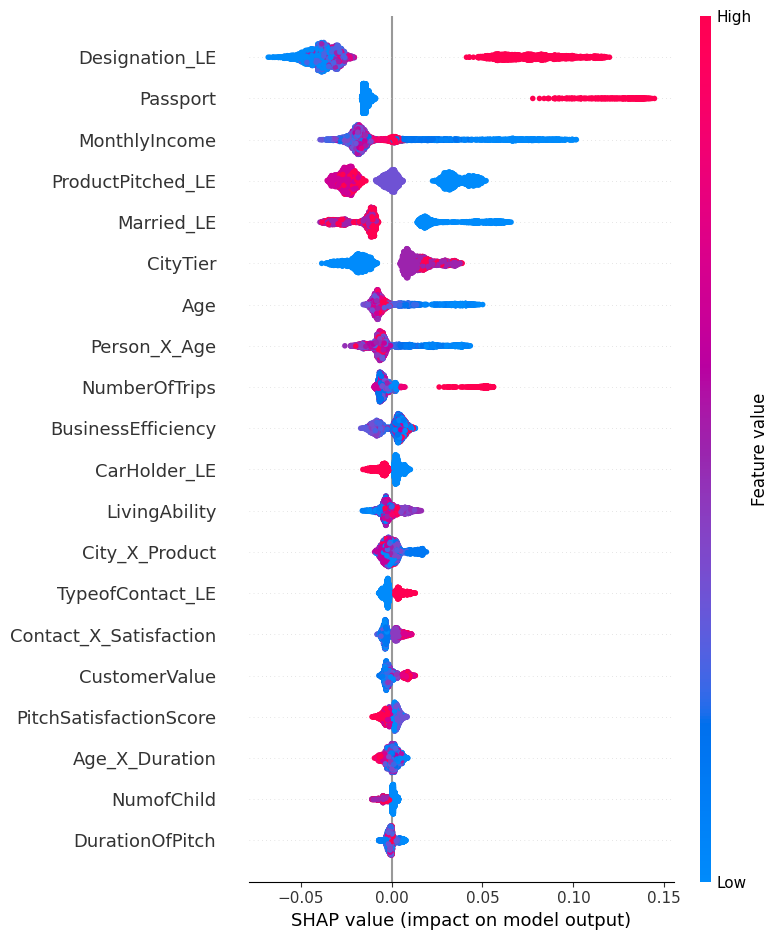

In [132]:
import shap
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()
# explainer = shap.TreeExplainer(model=models[0])

# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)

# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])

# ② SHAP値を計算
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))

# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

In [133]:
# 寄与度とSHAP値が低いものは削除
all_df2 = all_df2.drop("NumofChild", axis=1)
all_df2 = all_df2.drop("Married_X_Children", axis=1)
all_df2 = all_df2.drop("NumberOfPersonVisiting", axis=1)

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()
# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

KeyError: "['NumberOfPersonViiting'] not found in axis"

In [137]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

#########################
### Fold 1
#########################
[100]	train's auc: 0.861213	valid's auc: 0.836099
#########################
### Fold 2
#########################
[100]	train's auc: 0.878403	valid's auc: 0.794812
#########################
### Fold 3
#########################
[100]	train's auc: 0.86544	valid's auc: 0.831505
[200]	train's auc: 0.889391	valid's auc: 0.834171
[300]	train's auc: 0.906262	valid's auc: 0.834639
[400]	train's auc: 0.917755	valid's auc: 0.834171
CPU times: user 3.45 s, sys: 316 ms, total: 3.77 s
Wall time: 863 ms


In [138]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8236067474364905


In [139]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'regression',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      "learning_rate": 0.05,
      "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
      "num_leaves": trial.suggest_int("num_leaves", 2, 256),
      "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
      "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
      "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
      "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
      "min_data_in_leaf": trial.suggest_categorical("min_data_in_leaf", [5, 10, 25, 50, 100]),
      "max_bin": trial.suggest_int("max_bin", 100, 255),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-21 11:01:37,653] A new study created in memory with name: no-name-54cd36e6-6fbc-4dd4-a928-df49247b568e


#########################
### Fold 1
#########################
[100]	train's auc: 0.972596	valid's auc: 0.767689
#########################
### Fold 2
#########################
[100]	train's auc: 0.97289	valid's auc: 0.751133
#########################
### Fold 3
#########################
[100]	train's auc: 0.973517	valid's auc: 0.799642


[I 2025-05-21 11:01:38,793] Trial 0 finished with value: 0.791075328979223 and parameters: {'feature_fraction': 0.9787167879328117, 'num_leaves': 233, 'bagging_fraction': 0.4107016921935684, 'bagging_freq': 6, 'lambda_l1': 2.182958794427483e-06, 'lambda_l2': 7.629519446033893, 'min_data_in_leaf': 10, 'max_bin': 255}. Best is trial 0 with value: 0.791075328979223.


#########################
### Fold 1
#########################
[100]	train's auc: 0.890672	valid's auc: 0.82738
#########################
### Fold 2
#########################
[100]	train's auc: 0.900865	valid's auc: 0.789314
#########################
### Fold 3
#########################
[100]	train's auc: 0.892723	valid's auc: 0.828196


[I 2025-05-21 11:01:39,373] Trial 1 finished with value: 0.8164128487502555 and parameters: {'feature_fraction': 0.6429487033316518, 'num_leaves': 113, 'bagging_fraction': 0.705053891223616, 'bagging_freq': 7, 'lambda_l1': 5.2259629384871367e-08, 'lambda_l2': 2.150113886337911e-05, 'min_data_in_leaf': 100, 'max_bin': 225}. Best is trial 1 with value: 0.8164128487502555.


[200]	train's auc: 0.923167	valid's auc: 0.824923
#########################
### Fold 1
#########################
[100]	train's auc: 0.916457	valid's auc: 0.821199
#########################
### Fold 2
#########################
[100]	train's auc: 0.921064	valid's auc: 0.788317
#########################
### Fold 3
#########################
[100]	train's auc: 0.917451	valid's auc: 0.824783


[I 2025-05-21 11:01:40,648] Trial 2 finished with value: 0.8025176459828489 and parameters: {'feature_fraction': 0.6256508233816712, 'num_leaves': 189, 'bagging_fraction': 0.9588339429736662, 'bagging_freq': 6, 'lambda_l1': 7.305179128621443e-08, 'lambda_l2': 9.071240701097159e-07, 'min_data_in_leaf': 100, 'max_bin': 189}. Best is trial 1 with value: 0.8164128487502555.


#########################
### Fold 1
#########################
[100]	train's auc: 0.930739	valid's auc: 0.813277
#########################
### Fold 2
#########################
[100]	train's auc: 0.934566	valid's auc: 0.788595
#########################
### Fold 3
#########################
[100]	train's auc: 0.930661	valid's auc: 0.818631


[I 2025-05-21 11:01:42,110] Trial 3 finished with value: 0.8172598424773239 and parameters: {'feature_fraction': 0.48580986365144263, 'num_leaves': 220, 'bagging_fraction': 0.6260070733605886, 'bagging_freq': 2, 'lambda_l1': 5.426426066020364e-07, 'lambda_l2': 0.000167496628055211, 'min_data_in_leaf': 50, 'max_bin': 173}. Best is trial 3 with value: 0.8172598424773239.


#########################
### Fold 1
#########################
[100]	train's auc: 0.886852	valid's auc: 0.830818
#########################
### Fold 2
#########################
[100]	train's auc: 0.896866	valid's auc: 0.786861
#########################
### Fold 3
#########################
[100]	train's auc: 0.888258	valid's auc: 0.827844


[I 2025-05-21 11:01:42,646] Trial 4 finished with value: 0.8172531176362992 and parameters: {'feature_fraction': 0.6869605065233164, 'num_leaves': 168, 'bagging_fraction': 0.6471849154006846, 'bagging_freq': 3, 'lambda_l1': 0.01663495128778539, 'lambda_l2': 2.1406918195430355e-06, 'min_data_in_leaf': 100, 'max_bin': 245}. Best is trial 3 with value: 0.8172598424773239.


#########################
### Fold 1
#########################
[100]	train's auc: 0.999846	valid's auc: 0.779429
#########################
### Fold 2
#########################
[100]	train's auc: 0.999882	valid's auc: 0.757665
#########################
### Fold 3
#########################
[100]	train's auc: 0.99987	valid's auc: 0.798877


[I 2025-05-21 11:01:43,975] Trial 5 finished with value: 0.7901449472234476 and parameters: {'feature_fraction': 0.7994286536727897, 'num_leaves': 67, 'bagging_fraction': 0.5385188255681309, 'bagging_freq': 2, 'lambda_l1': 3.208740411573356e-08, 'lambda_l2': 5.178698047121044e-05, 'min_data_in_leaf': 5, 'max_bin': 135}. Best is trial 3 with value: 0.8172598424773239.


[200]	train's auc: 1	valid's auc: 0.789361
#########################
### Fold 1
#########################
[100]	train's auc: 0.908657	valid's auc: 0.821507
#########################
### Fold 2
#########################
[100]	train's auc: 0.914107	valid's auc: 0.783707
#########################
### Fold 3
#########################


[I 2025-05-21 11:01:44,559] Trial 6 finished with value: 0.801935274750105 and parameters: {'feature_fraction': 0.5518085408873694, 'num_leaves': 170, 'bagging_fraction': 0.677355460682153, 'bagging_freq': 6, 'lambda_l1': 1.765486199833893, 'lambda_l2': 0.35768461691378933, 'min_data_in_leaf': 50, 'max_bin': 232}. Best is trial 3 with value: 0.8172598424773239.


[100]	train's auc: 0.90938	valid's auc: 0.822852
#########################
### Fold 1
#########################
[100]	train's auc: 0.999995	valid's auc: 0.785586
#########################
### Fold 2
#########################
[100]	train's auc: 0.999876	valid's auc: 0.763157
#########################
### Fold 3
#########################


[I 2025-05-21 11:01:46,137] Trial 7 finished with value: 0.7856786440568546 and parameters: {'feature_fraction': 0.8596391207539258, 'num_leaves': 191, 'bagging_fraction': 0.63536602310196, 'bagging_freq': 3, 'lambda_l1': 0.24936495292158242, 'lambda_l2': 1.6438036268631537, 'min_data_in_leaf': 5, 'max_bin': 251}. Best is trial 3 with value: 0.8172598424773239.


[100]	train's auc: 0.999977	valid's auc: 0.785875
#########################
### Fold 1
#########################
[100]	train's auc: 0.91522	valid's auc: 0.824957
#########################
### Fold 2
#########################
[100]	train's auc: 0.917558	valid's auc: 0.793749
#########################
### Fold 3
#########################
[100]	train's auc: 0.919274	valid's auc: 0.823556


[I 2025-05-21 11:01:46,719] Trial 8 finished with value: 0.8136580176244633 and parameters: {'feature_fraction': 0.43805401195183236, 'num_leaves': 223, 'bagging_fraction': 0.5328455198963054, 'bagging_freq': 4, 'lambda_l1': 0.13701862000206924, 'lambda_l2': 1.8590174025086853e-07, 'min_data_in_leaf': 50, 'max_bin': 178}. Best is trial 3 with value: 0.8172598424773239.


#########################
### Fold 1
#########################
[100]	train's auc: 0.907673	valid's auc: 0.816286
#########################
### Fold 2
#########################


[I 2025-05-21 11:01:47,203] Trial 9 finished with value: 0.8080249545400746 and parameters: {'feature_fraction': 0.8722853229808414, 'num_leaves': 206, 'bagging_fraction': 0.4281759171750428, 'bagging_freq': 5, 'lambda_l1': 6.87592089647805e-08, 'lambda_l2': 0.04624088398129101, 'min_data_in_leaf': 50, 'max_bin': 134}. Best is trial 3 with value: 0.8172598424773239.


[100]	train's auc: 0.912852	valid's auc: 0.780534
#########################
### Fold 3
#########################
[100]	train's auc: 0.910504	valid's auc: 0.813148
#########################
### Fold 1
#########################
[100]	train's auc: 0.870459	valid's auc: 0.836522
#########################
### Fold 2
#########################
[100]	train's auc: 0.885683	valid's auc: 0.795471
#########################
### Fold 3
#########################
[100]	train's auc: 0.872817	valid's auc: 0.833764


[I 2025-05-21 11:01:47,704] Trial 10 finished with value: 0.8230600178611778 and parameters: {'feature_fraction': 0.41732584417515795, 'num_leaves': 6, 'bagging_fraction': 0.881344691528159, 'bagging_freq': 1, 'lambda_l1': 6.153756203158947e-05, 'lambda_l2': 0.003470491457235247, 'min_data_in_leaf': 25, 'max_bin': 104}. Best is trial 10 with value: 0.8230600178611778.


#########################
### Fold 1
#########################
[100]	train's auc: 0.894352	valid's auc: 0.824371
#########################
### Fold 2
#########################
[100]	train's auc: 0.906387	valid's auc: 0.787374
#########################
### Fold 3
#########################
[100]	train's auc: 0.894572	valid's auc: 0.830418


[I 2025-05-21 11:01:48,247] Trial 11 finished with value: 0.8154622924714059 and parameters: {'feature_fraction': 0.40372737999086566, 'num_leaves': 9, 'bagging_fraction': 0.8755259839377898, 'bagging_freq': 1, 'lambda_l1': 3.738324800066664e-05, 'lambda_l2': 0.0035735515744862605, 'min_data_in_leaf': 25, 'max_bin': 101}. Best is trial 10 with value: 0.8230600178611778.


#########################
### Fold 1
#########################
[100]	train's auc: 0.931056	valid's auc: 0.815851
#########################
### Fold 2
#########################
[100]	train's auc: 0.937287	valid's auc: 0.785205
#########################
### Fold 3
#########################


[I 2025-05-21 11:01:48,833] Trial 12 finished with value: 0.8029604767643294 and parameters: {'feature_fraction': 0.5073343127657365, 'num_leaves': 15, 'bagging_fraction': 0.8097370720770156, 'bagging_freq': 1, 'lambda_l1': 0.00043100485033909804, 'lambda_l2': 0.0018049317281904902, 'min_data_in_leaf': 25, 'max_bin': 147}. Best is trial 10 with value: 0.8230600178611778.


[100]	train's auc: 0.935428	valid's auc: 0.813925
#########################
### Fold 1
#########################
[100]	train's auc: 0.987994	valid's auc: 0.799549
#########################
### Fold 2
#########################
[100]	train's auc: 0.98634	valid's auc: 0.775453
#########################
### Fold 3
#########################


[I 2025-05-21 11:01:49,660] Trial 13 finished with value: 0.7975651368101659 and parameters: {'feature_fraction': 0.5156937237325816, 'num_leaves': 93, 'bagging_fraction': 0.8045226374569463, 'bagging_freq': 2, 'lambda_l1': 9.265479442406222e-06, 'lambda_l2': 0.0004715792746152082, 'min_data_in_leaf': 25, 'max_bin': 108}. Best is trial 10 with value: 0.8230600178611778.


[100]	train's auc: 0.985381	valid's auc: 0.811198
#########################
### Fold 1
#########################
[100]	train's auc: 0.995053	valid's auc: 0.788492
#########################
### Fold 2
#########################
[100]	train's auc: 0.995583	valid's auc: 0.76471
#########################
### Fold 3
#########################


[I 2025-05-21 11:01:50,499] Trial 14 finished with value: 0.7851009802128278 and parameters: {'feature_fraction': 0.47421666495564013, 'num_leaves': 46, 'bagging_fraction': 0.9683390888869471, 'bagging_freq': 2, 'lambda_l1': 0.0007027837184440856, 'lambda_l2': 0.023960671600773736, 'min_data_in_leaf': 10, 'max_bin': 206}. Best is trial 10 with value: 0.8230600178611778.


[100]	train's auc: 0.994387	valid's auc: 0.813931
#########################
### Fold 1
#########################
[100]	train's auc: 0.984946	valid's auc: 0.794999
#########################
### Fold 2
#########################
[100]	train's auc: 0.984728	valid's auc: 0.768571
#########################
### Fold 3
#########################


[I 2025-05-21 11:01:51,417] Trial 15 finished with value: 0.8075010894242459 and parameters: {'feature_fraction': 0.5570176799727192, 'num_leaves': 250, 'bagging_fraction': 0.7546464352392219, 'bagging_freq': 1, 'lambda_l1': 2.210636028168071e-06, 'lambda_l2': 1.4857308548339713e-08, 'min_data_in_leaf': 25, 'max_bin': 159}. Best is trial 10 with value: 0.8230600178611778.


[100]	train's auc: 0.984369	valid's auc: 0.800729
#########################
### Fold 1
#########################
[100]	train's auc: 0.91847	valid's auc: 0.815519
#########################
### Fold 2
#########################
[100]	train's auc: 0.924277	valid's auc: 0.789592
#########################
### Fold 3
#########################


[I 2025-05-21 11:01:53,651] Trial 16 finished with value: 0.811499343655516 and parameters: {'feature_fraction': 0.4058877476260324, 'num_leaves': 138, 'bagging_fraction': 0.5523407267002901, 'bagging_freq': 3, 'lambda_l1': 0.0028483948278218846, 'lambda_l2': 4.3840669155742996e-05, 'min_data_in_leaf': 50, 'max_bin': 118}. Best is trial 10 with value: 0.8230600178611778.


[100]	train's auc: 0.920105	valid's auc: 0.81916
#########################
### Fold 1
#########################
[100]	train's auc: 0.990311	valid's auc: 0.795646
#########################
### Fold 2
#########################
[100]	train's auc: 0.989266	valid's auc: 0.757217
#########################
### Fold 3
#########################


[I 2025-05-21 11:01:54,504] Trial 17 finished with value: 0.7939421287080775 and parameters: {'feature_fraction': 0.5960083684363471, 'num_leaves': 136, 'bagging_fraction': 0.8720029574191325, 'bagging_freq': 4, 'lambda_l1': 6.487850076467388e-05, 'lambda_l2': 0.015422445235496117, 'min_data_in_leaf': 25, 'max_bin': 162}. Best is trial 10 with value: 0.8230600178611778.


[100]	train's auc: 0.98847	valid's auc: 0.797267
#########################
### Fold 1
#########################
[100]	train's auc: 0.935481	valid's auc: 0.819797
#########################
### Fold 2
#########################
[100]	train's auc: 0.937829	valid's auc: 0.791555
#########################
### Fold 3
#########################
[100]	train's auc: 0.936247	valid's auc: 0.824461


[I 2025-05-21 11:01:55,150] Trial 18 finished with value: 0.8164141937184606 and parameters: {'feature_fraction': 0.7142819714202348, 'num_leaves': 64, 'bagging_fraction': 0.5978145141805, 'bagging_freq': 2, 'lambda_l1': 1.393333073247037e-06, 'lambda_l2': 0.000681993641811758, 'min_data_in_leaf': 50, 'max_bin': 197}. Best is trial 10 with value: 0.8230600178611778.


#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.787006
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.752359
#########################
### Fold 3
#########################


[I 2025-05-21 11:01:56,634] Trial 19 finished with value: 0.7925635362980019 and parameters: {'feature_fraction': 0.4590385752887251, 'num_leaves': 106, 'bagging_fraction': 0.7342345385328402, 'bagging_freq': 1, 'lambda_l1': 4.5068229202835995e-07, 'lambda_l2': 0.17726314604917295, 'min_data_in_leaf': 5, 'max_bin': 121}. Best is trial 10 with value: 0.8230600178611778.


[100]	train's auc: 1	valid's auc: 0.796666
#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.755193
#########################
### Fold 2
#########################
[100]	train's auc: 0.999971	valid's auc: 0.750251
#########################
### Fold 3
#########################


[I 2025-05-21 11:01:58,327] Trial 20 finished with value: 0.7820586621332271 and parameters: {'feature_fraction': 0.7604290732723842, 'num_leaves': 159, 'bagging_fraction': 0.8819904984029061, 'bagging_freq': 3, 'lambda_l1': 3.575478951388165e-05, 'lambda_l2': 8.065845724637714e-06, 'min_data_in_leaf': 10, 'max_bin': 169}. Best is trial 10 with value: 0.8230600178611778.


[100]	train's auc: 0.999986	valid's auc: 0.791012
#########################
### Fold 1
#########################
[100]	train's auc: 0.88403	valid's auc: 0.829954
#########################
### Fold 2
#########################
[100]	train's auc: 0.894593	valid's auc: 0.792444
#########################
### Fold 3
#########################
[100]	train's auc: 0.884751	valid's auc: 0.827904


[I 2025-05-21 11:01:58,962] Trial 21 finished with value: 0.8186283476258621 and parameters: {'feature_fraction': 0.6663971859873354, 'num_leaves': 159, 'bagging_fraction': 0.6195185979729866, 'bagging_freq': 3, 'lambda_l1': 0.007413059681441276, 'lambda_l2': 2.0746672896069995e-06, 'min_data_in_leaf': 100, 'max_bin': 219}. Best is trial 10 with value: 0.8230600178611778.


[200]	train's auc: 0.917252	valid's auc: 0.820599
#########################
### Fold 1
#########################
[100]	train's auc: 0.879711	valid's auc: 0.830618
[200]	train's auc: 0.90894	valid's auc: 0.825688
#########################
### Fold 2
#########################
[100]	train's auc: 0.890815	valid's auc: 0.796027
#########################
### Fold 3
#########################
[100]	train's auc: 0.882805	valid's auc: 0.82675


[I 2025-05-21 11:01:59,697] Trial 22 finished with value: 0.8202019604256555 and parameters: {'feature_fraction': 0.5611709575186169, 'num_leaves': 251, 'bagging_fraction': 0.5746755104318286, 'bagging_freq': 2, 'lambda_l1': 0.02053591258498106, 'lambda_l2': 0.00014550561066795567, 'min_data_in_leaf': 100, 'max_bin': 220}. Best is trial 10 with value: 0.8230600178611778.


[200]	train's auc: 0.910308	valid's auc: 0.823593
#########################
### Fold 1
#########################
[100]	train's auc: 0.875777	valid's auc: 0.833984
#########################
### Fold 2
#########################
[100]	train's auc: 0.883465	valid's auc: 0.790625
#########################
### Fold 3
#########################
[100]	train's auc: 0.878826	valid's auc: 0.823477
[200]	train's auc: 0.902642	valid's auc: 0.823957


[I 2025-05-21 11:02:00,412] Trial 23 finished with value: 0.8198146095826295 and parameters: {'feature_fraction': 0.6842814419700533, 'num_leaves': 35, 'bagging_fraction': 0.5004121144208326, 'bagging_freq': 3, 'lambda_l1': 0.013757900441964874, 'lambda_l2': 1.9148791495880753e-07, 'min_data_in_leaf': 100, 'max_bin': 221}. Best is trial 10 with value: 0.8230600178611778.


#########################
### Fold 1
#########################
[100]	train's auc: 0.837026	valid's auc: 0.838286
[200]	train's auc: 0.84645	valid's auc: 0.842522
#########################
### Fold 2
#########################
[100]	train's auc: 0.853947	valid's auc: 0.79754
[200]	train's auc: 0.862113	valid's auc: 0.801489
[300]	train's auc: 0.86759	valid's auc: 0.802709
#########################
### Fold 3
#########################
[100]	train's auc: 0.839446	valid's auc: 0.817997


[I 2025-05-21 11:02:01,383] Trial 24 finished with value: 0.8231292837237328 and parameters: {'feature_fraction': 0.5933355995265598, 'num_leaves': 31, 'bagging_fraction': 0.4752572004088315, 'bagging_freq': 1, 'lambda_l1': 8.246628939664804, 'lambda_l2': 1.8858351570561494e-08, 'min_data_in_leaf': 100, 'max_bin': 211}. Best is trial 24 with value: 0.8231292837237328.


[200]	train's auc: 0.850553	valid's auc: 0.825858
[300]	train's auc: 0.855271	valid's auc: 0.827431
#########################
### Fold 1
#########################
[100]	train's auc: 0.837826	valid's auc: 0.839126
[200]	train's auc: 0.84898	valid's auc: 0.841446
#########################
### Fold 2
#########################
[100]	train's auc: 0.854487	valid's auc: 0.79906
[200]	train's auc: 0.863084	valid's auc: 0.802389
[300]	train's auc: 0.869408	valid's auc: 0.802359
#########################
### Fold 3
#########################
[100]	train's auc: 0.841882	valid's auc: 0.8195


[I 2025-05-21 11:02:02,371] Trial 25 finished with value: 0.82278631683147 and parameters: {'feature_fraction': 0.5980828712066916, 'num_leaves': 29, 'bagging_fraction': 0.4789269239501851, 'bagging_freq': 1, 'lambda_l1': 7.739332826431522, 'lambda_l2': 2.892037017168393e-08, 'min_data_in_leaf': 100, 'max_bin': 205}. Best is trial 24 with value: 0.8231292837237328.


[200]	train's auc: 0.851632	valid's auc: 0.826046
[300]	train's auc: 0.856858	valid's auc: 0.826963
#########################
### Fold 1
#########################
[100]	train's auc: 0.808633	valid's auc: 0.830195
[200]	train's auc: 0.817523	valid's auc: 0.839256
[300]	train's auc: 0.821103	valid's auc: 0.841935
[400]	train's auc: 0.824814	valid's auc: 0.842951
[500]	train's auc: 0.827041	valid's auc: 0.844117
[600]	train's auc: 0.828899	valid's auc: 0.845083
[700]	train's auc: 0.830445	valid's auc: 0.845525
#########################
### Fold 2
#########################
[100]	train's auc: 0.834595	valid's auc: 0.783525
[200]	train's auc: 0.840295	valid's auc: 0.788634
[300]	train's auc: 0.843163	valid's auc: 0.79019
[400]	train's auc: 0.845385	valid's auc: 0.791598
[500]	train's auc: 0.846844	valid's auc: 0.792857
[600]	train's auc: 0.848042	valid's auc: 0.794132
[700]	train's auc: 0.849332	valid's auc: 0.795788
[800]	train's auc: 0.850121	valid's auc: 0.796507
[900]	train's auc: 0.8508

[I 2025-05-21 11:02:07,082] Trial 26 finished with value: 0.8235428614467553 and parameters: {'feature_fraction': 0.5888240735761082, 'num_leaves': 2, 'bagging_fraction': 0.4660227386693665, 'bagging_freq': 1, 'lambda_l1': 9.363128558346299, 'lambda_l2': 1.0342332575283535e-08, 'min_data_in_leaf': 100, 'max_bin': 201}. Best is trial 26 with value: 0.8235428614467553.


[1300]	train's auc: 0.835158	valid's auc: 0.828627
[1400]	train's auc: 0.835653	valid's auc: 0.828615
#########################
### Fold 1
#########################
[100]	train's auc: 0.839557	valid's auc: 0.839857
[200]	train's auc: 0.851061	valid's auc: 0.840238
#########################
### Fold 2
#########################
[100]	train's auc: 0.857019	valid's auc: 0.796392
[200]	train's auc: 0.865517	valid's auc: 0.79912
[300]	train's auc: 0.872065	valid's auc: 0.800383
#########################
### Fold 3
#########################
[100]	train's auc: 0.840889	valid's auc: 0.819047
[200]	train's auc: 0.85144	valid's auc: 0.825299
[300]	train's auc: 0.85753	valid's auc: 0.826647
[400]	train's auc: 0.861204	valid's auc: 0.828706


[I 2025-05-21 11:02:08,250] Trial 27 finished with value: 0.8214944748706141 and parameters: {'feature_fraction': 0.7386179780748667, 'num_leaves': 9, 'bagging_fraction': 0.49207956571766065, 'bagging_freq': 1, 'lambda_l1': 8.048116342466528, 'lambda_l2': 9.457040346603533e-08, 'min_data_in_leaf': 100, 'max_bin': 190}. Best is trial 26 with value: 0.8235428614467553.


[500]	train's auc: 0.865141	valid's auc: 0.828694
#########################
### Fold 1
#########################
[100]	train's auc: 0.94243	valid's auc: 0.81402
#########################
### Fold 2
#########################
[100]	train's auc: 0.945747	valid's auc: 0.777954
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:09,075] Trial 28 finished with value: 0.8119720999795565 and parameters: {'feature_fraction': 0.5301974869814315, 'num_leaves': 63, 'bagging_fraction': 0.4597108583621785, 'bagging_freq': 1, 'lambda_l1': 0.6419845004220996, 'lambda_l2': 5.06250809591642e-08, 'min_data_in_leaf': 25, 'max_bin': 209}. Best is trial 26 with value: 0.8235428614467553.


[100]	train's auc: 0.942505	valid's auc: 0.825931
#########################
### Fold 1
#########################
[100]	train's auc: 0.922662	valid's auc: 0.826395
#########################
### Fold 2
#########################
[100]	train's auc: 0.927185	valid's auc: 0.782625
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:10,041] Trial 29 finished with value: 0.8129788086809628 and parameters: {'feature_fraction': 0.6167862464422423, 'num_leaves': 43, 'bagging_fraction': 0.4121175194733133, 'bagging_freq': 4, 'lambda_l1': 1.9513993676235464, 'lambda_l2': 9.97395614718798, 'min_data_in_leaf': 10, 'max_bin': 237}. Best is trial 26 with value: 0.8235428614467553.


[100]	train's auc: 0.923797	valid's auc: 0.822244
[200]	train's auc: 0.955198	valid's auc: 0.817599
#########################
### Fold 1
#########################
[100]	train's auc: 0.871756	valid's auc: 0.832431
#########################
### Fold 2
#########################
[100]	train's auc: 0.882352	valid's auc: 0.795093
#########################
### Fold 3
#########################
[100]	train's auc: 0.868867	valid's auc: 0.823441


[I 2025-05-21 11:02:10,660] Trial 30 finished with value: 0.8231978771021853 and parameters: {'feature_fraction': 0.9612000076762934, 'num_leaves': 83, 'bagging_fraction': 0.4391986235222933, 'bagging_freq': 2, 'lambda_l1': 0.09767837842208997, 'lambda_l2': 3.80820760806031e-07, 'min_data_in_leaf': 100, 'max_bin': 184}. Best is trial 26 with value: 0.8235428614467553.


[200]	train's auc: 0.894279	valid's auc: 0.828056
#########################
### Fold 1
#########################
[100]	train's auc: 0.816558	valid's auc: 0.839503
[200]	train's auc: 0.829919	valid's auc: 0.843168
[300]	train's auc: 0.835677	valid's auc: 0.842491
#########################
### Fold 2
#########################
[100]	train's auc: 0.839919	valid's auc: 0.784966
[200]	train's auc: 0.849355	valid's auc: 0.794413
[300]	train's auc: 0.853249	valid's auc: 0.795413
[400]	train's auc: 0.856033	valid's auc: 0.796616
[500]	train's auc: 0.858318	valid's auc: 0.797292
#########################
### Fold 3
#########################
[100]	train's auc: 0.820643	valid's auc: 0.819014
[200]	train's auc: 0.831801	valid's auc: 0.830242
[300]	train's auc: 0.836785	valid's auc: 0.832732
[400]	train's auc: 0.839377	valid's auc: 0.834396


[I 2025-05-21 11:02:11,800] Trial 31 finished with value: 0.8247331583081376 and parameters: {'feature_fraction': 0.996029690316007, 'num_leaves': 2, 'bagging_fraction': 0.44301945124333647, 'bagging_freq': 1, 'lambda_l1': 0.08237657069235632, 'lambda_l2': 1.1261961277275915e-08, 'min_data_in_leaf': 100, 'max_bin': 184}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.870978	valid's auc: 0.833706
#########################
### Fold 2
#########################
[100]	train's auc: 0.881189	valid's auc: 0.790577
#########################
### Fold 3
#########################
[100]	train's auc: 0.869585	valid's auc: 0.820228


[I 2025-05-21 11:02:12,367] Trial 32 finished with value: 0.8217167308664822 and parameters: {'feature_fraction': 0.9852201439151459, 'num_leaves': 24, 'bagging_fraction': 0.44551783093534064, 'bagging_freq': 2, 'lambda_l1': 0.10773370609670466, 'lambda_l2': 1.0480891028988946e-08, 'min_data_in_leaf': 100, 'max_bin': 182}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.893329	valid's auc: 0.823744
#########################
### Fold 1
#########################
[100]	train's auc: 0.854931	valid's auc: 0.840618
#########################
### Fold 2
#########################
[100]	train's auc: 0.874591	valid's auc: 0.79474
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:13,047] Trial 33 finished with value: 0.8216824341772561 and parameters: {'feature_fraction': 0.9201620989586472, 'num_leaves': 93, 'bagging_fraction': 0.4066669701454715, 'bagging_freq': 1, 'lambda_l1': 1.7104812080777003, 'lambda_l2': 6.834431985332841e-07, 'min_data_in_leaf': 100, 'max_bin': 194}. Best is trial 31 with value: 0.8247331583081376.


[100]	train's auc: 0.858554	valid's auc: 0.821321
[200]	train's auc: 0.879509	valid's auc: 0.82106
#########################
### Fold 1
#########################
[100]	train's auc: 0.876227	valid's auc: 0.831241
#########################
### Fold 2
#########################
[100]	train's auc: 0.884687	valid's auc: 0.793598
[200]	train's auc: 0.908731	valid's auc: 0.790504
#########################
### Fold 3
#########################
[100]	train's auc: 0.876122	valid's auc: 0.824412


[I 2025-05-21 11:02:13,706] Trial 34 finished with value: 0.8176747651685514 and parameters: {'feature_fraction': 0.941106634864187, 'num_leaves': 52, 'bagging_fraction': 0.517029566296508, 'bagging_freq': 7, 'lambda_l1': 0.04242519390801497, 'lambda_l2': 3.1739880458683975e-07, 'min_data_in_leaf': 100, 'max_bin': 184}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.904346	valid's auc: 0.82584
#########################
### Fold 1
#########################
[100]	train's auc: 0.814963	valid's auc: 0.839008
[200]	train's auc: 0.825983	valid's auc: 0.841268
#########################
### Fold 2
#########################
[100]	train's auc: 0.839689	valid's auc: 0.778888
[200]	train's auc: 0.849379	valid's auc: 0.790012
[300]	train's auc: 0.852149	valid's auc: 0.792861
[400]	train's auc: 0.856287	valid's auc: 0.797018
[500]	train's auc: 0.857534	valid's auc: 0.797211
[600]	train's auc: 0.860299	valid's auc: 0.79599
#########################
### Fold 3
#########################
[100]	train's auc: 0.816159	valid's auc: 0.816843
[200]	train's auc: 0.830562	valid's auc: 0.824838


[I 2025-05-21 11:02:14,673] Trial 35 finished with value: 0.8218381142469792 and parameters: {'feature_fraction': 0.9462354884463442, 'num_leaves': 2, 'bagging_fraction': 0.44910549720661325, 'bagging_freq': 2, 'lambda_l1': 0.40673439550388135, 'lambda_l2': 4.550875682319382e-08, 'min_data_in_leaf': 100, 'max_bin': 200}. Best is trial 31 with value: 0.8247331583081376.


[300]	train's auc: 0.835707	valid's auc: 0.831727
#########################
### Fold 1
#########################
[100]	train's auc: 0.872795	valid's auc: 0.838836
#########################
### Fold 2
#########################
[100]	train's auc: 0.884454	valid's auc: 0.792365
#########################
### Fold 3
#########################
[100]	train's auc: 0.875364	valid's auc: 0.82403


[I 2025-05-21 11:02:16,881] Trial 36 finished with value: 0.822127618653095 and parameters: {'feature_fraction': 0.9102366863310687, 'num_leaves': 82, 'bagging_fraction': 0.4738051901467316, 'bagging_freq': 2, 'lambda_l1': 0.0022179312670111834, 'lambda_l2': 1.1801515279013038e-08, 'min_data_in_leaf': 100, 'max_bin': 210}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.898983	valid's auc: 0.822172
#########################
### Fold 1
#########################
[100]	train's auc: 0.847756	valid's auc: 0.841029
[200]	train's auc: 0.865699	valid's auc: 0.841742
#########################
### Fold 2
#########################
[100]	train's auc: 0.864507	valid's auc: 0.797371
#########################
### Fold 3
#########################
[100]	train's auc: 0.850043	valid's auc: 0.812467
[200]	train's auc: 0.868218	valid's auc: 0.823325
[300]	train's auc: 0.87943	valid's auc: 0.826866


[I 2025-05-21 11:02:17,726] Trial 37 finished with value: 0.8238168987185142 and parameters: {'feature_fraction': 0.8185521733681053, 'num_leaves': 25, 'bagging_fraction': 0.40312027601977957, 'bagging_freq': 1, 'lambda_l1': 3.6478602753278335, 'lambda_l2': 5.860844796553409e-06, 'min_data_in_leaf': 100, 'max_bin': 171}. Best is trial 31 with value: 0.8247331583081376.


[400]	train's auc: 0.888935	valid's auc: 0.828827
#########################
### Fold 1
#########################
[100]	train's auc: 0.858541	valid's auc: 0.841404
#########################
### Fold 2
#########################
[100]	train's auc: 0.872842	valid's auc: 0.80025
#########################
### Fold 3
#########################
[100]	train's auc: 0.859885	valid's auc: 0.821057
[200]	train's auc: 0.883196	valid's auc: 0.823939


[I 2025-05-21 11:02:18,413] Trial 38 finished with value: 0.8234036572375427 and parameters: {'feature_fraction': 0.8254213865367594, 'num_leaves': 17, 'bagging_fraction': 0.4002380657111182, 'bagging_freq': 2, 'lambda_l1': 0.8085313123112492, 'lambda_l2': 3.936491209532095e-06, 'min_data_in_leaf': 100, 'max_bin': 169}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.858504	valid's auc: 0.8386
#########################
### Fold 2
#########################
[100]	train's auc: 0.869546	valid's auc: 0.792009
#########################
### Fold 3
#########################
[100]	train's auc: 0.861709	valid's auc: 0.81404
[200]	train's auc: 0.881748	valid's auc: 0.815807
[300]	train's auc: 0.896223	valid's auc: 0.8195
[400]	train's auc: 0.90906	valid's auc: 0.818291


[I 2025-05-21 11:02:19,203] Trial 39 finished with value: 0.8214981735331777 and parameters: {'feature_fraction': 0.8083751883599339, 'num_leaves': 22, 'bagging_fraction': 0.40549101351484995, 'bagging_freq': 6, 'lambda_l1': 1.0156363308483733, 'lambda_l2': 6.411898374641545e-06, 'min_data_in_leaf': 100, 'max_bin': 155}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.941531	valid's auc: 0.816171
#########################
### Fold 2
#########################
[100]	train's auc: 0.943015	valid's auc: 0.787694
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:20,111] Trial 40 finished with value: 0.8046662326902593 and parameters: {'feature_fraction': 0.8422152629385502, 'num_leaves': 53, 'bagging_fraction': 0.5541998364895221, 'bagging_freq': 5, 'lambda_l1': 3.21643763338648, 'lambda_l2': 1.8714703099366698e-06, 'min_data_in_leaf': 5, 'max_bin': 174}. Best is trial 31 with value: 0.8247331583081376.


[100]	train's auc: 0.943931	valid's auc: 0.805666
#########################
### Fold 1
#########################
[100]	train's auc: 0.871934	valid's auc: 0.832745
#########################
### Fold 2
#########################
[100]	train's auc: 0.8819	valid's auc: 0.792468
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:20,663] Trial 41 finished with value: 0.819693898686235 and parameters: {'feature_fraction': 0.9677446111952706, 'num_leaves': 17, 'bagging_fraction': 0.435493834112809, 'bagging_freq': 2, 'lambda_l1': 0.05930359240138179, 'lambda_l2': 1.066863004219267e-05, 'min_data_in_leaf': 100, 'max_bin': 168}. Best is trial 31 with value: 0.8247331583081376.


[100]	train's auc: 0.869653	valid's auc: 0.822897
[200]	train's auc: 0.893622	valid's auc: 0.826799
#########################
### Fold 1
#########################
[100]	train's auc: 0.869506	valid's auc: 0.831923
#########################
### Fold 2
#########################
[100]	train's auc: 0.881497	valid's auc: 0.792063
#########################
### Fold 3
#########################
[100]	train's auc: 0.869434	valid's auc: 0.824668
[200]	train's auc: 0.892837	valid's auc: 0.826805


[I 2025-05-21 11:02:21,253] Trial 42 finished with value: 0.8156092302477969 and parameters: {'feature_fraction': 0.8814859542613772, 'num_leaves': 38, 'bagging_fraction': 0.4362065929813203, 'bagging_freq': 1, 'lambda_l1': 0.2422440076602058, 'lambda_l2': 5.956539878758354e-07, 'min_data_in_leaf': 100, 'max_bin': 147}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.816376	valid's auc: 0.8387
[200]	train's auc: 0.826392	valid's auc: 0.839325
#########################
### Fold 2
#########################
[100]	train's auc: 0.842194	valid's auc: 0.788142
[200]	train's auc: 0.849026	valid's auc: 0.794685
[300]	train's auc: 0.852483	valid's auc: 0.796604
[400]	train's auc: 0.85535	valid's auc: 0.799135
[500]	train's auc: 0.856159	valid's auc: 0.797054
#########################
### Fold 3
#########################
[100]	train's auc: 0.815528	valid's auc: 0.8078
[200]	train's auc: 0.828039	valid's auc: 0.822141
[300]	train's auc: 0.833668	valid's auc: 0.826107
[400]	train's auc: 0.836894	valid's auc: 0.828178


[I 2025-05-21 11:02:22,262] Trial 43 finished with value: 0.8215603783126567 and parameters: {'feature_fraction': 0.8071180430896959, 'num_leaves': 2, 'bagging_fraction': 0.4002066542882127, 'bagging_freq': 2, 'lambda_l1': 0.5965276570467509, 'lambda_l2': 9.757668079912787e-08, 'min_data_in_leaf': 100, 'max_bin': 184}. Best is trial 31 with value: 0.8247331583081376.


[500]	train's auc: 0.838586	valid's auc: 0.827206
#########################
### Fold 1
#########################
[100]	train's auc: 0.855663	valid's auc: 0.838503
[200]	train's auc: 0.879689	valid's auc: 0.834745
#########################
### Fold 2
#########################
[100]	train's auc: 0.871108	valid's auc: 0.795882
[200]	train's auc: 0.889284	valid's auc: 0.795682
#########################
### Fold 3
#########################
[100]	train's auc: 0.857323	valid's auc: 0.823125


[I 2025-05-21 11:02:23,072] Trial 44 finished with value: 0.8187776390966119 and parameters: {'feature_fraction': 0.9936500599957256, 'num_leaves': 78, 'bagging_fraction': 0.49937575458580513, 'bagging_freq': 1, 'lambda_l1': 3.4641591074211835, 'lambda_l2': 2.7138607995706607e-05, 'min_data_in_leaf': 100, 'max_bin': 177}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.878778	valid's auc: 0.821989
#########################
### Fold 1
#########################
[100]	train's auc: 0.875665	valid's auc: 0.838256
[200]	train's auc: 0.904606	valid's auc: 0.828824
#########################
### Fold 2
#########################
[100]	train's auc: 0.888261	valid's auc: 0.796099
[200]	train's auc: 0.91119	valid's auc: 0.792667
#########################
### Fold 3
#########################
[100]	train's auc: 0.879199	valid's auc: 0.824018


[I 2025-05-21 11:02:23,896] Trial 45 finished with value: 0.8203579767374298 and parameters: {'feature_fraction': 0.7663441482774248, 'num_leaves': 17, 'bagging_fraction': 0.5164643391825392, 'bagging_freq': 1, 'lambda_l1': 0.20592564944205424, 'lambda_l2': 3.4404727048403825e-06, 'min_data_in_leaf': 100, 'max_bin': 150}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.90472	valid's auc: 0.822032
#########################
### Fold 1
#########################
[100]	train's auc: 0.871699	valid's auc: 0.844546
#########################
### Fold 2
#########################
[100]	train's auc: 0.879299	valid's auc: 0.793169
#########################
### Fold 3
#########################
[100]	train's auc: 0.872914	valid's auc: 0.824078
[200]	train's auc: 0.896426	valid's auc: 0.820034


[I 2025-05-21 11:02:24,525] Trial 46 finished with value: 0.8221918408848815 and parameters: {'feature_fraction': 0.9001642334688043, 'num_leaves': 56, 'bagging_fraction': 0.45556622522922324, 'bagging_freq': 2, 'lambda_l1': 0.08089568314503333, 'lambda_l2': 3.1291249310159197e-07, 'min_data_in_leaf': 100, 'max_bin': 166}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.86241	valid's auc: 0.839664
#########################
### Fold 2
#########################
[100]	train's auc: 0.875898	valid's auc: 0.792619
#########################
### Fold 3
#########################
[100]	train's auc: 0.86391	valid's auc: 0.823283


[I 2025-05-21 11:02:25,191] Trial 47 finished with value: 0.8203283874369209 and parameters: {'feature_fraction': 0.8616355116304244, 'num_leaves': 75, 'bagging_fraction': 0.4282783738928079, 'bagging_freq': 1, 'lambda_l1': 1.1537282879189958, 'lambda_l2': 1.3132572096211213e-06, 'min_data_in_leaf': 100, 'max_bin': 137}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.884693	valid's auc: 0.828639
#########################
### Fold 1
#########################
[100]	train's auc: 0.961834	valid's auc: 0.820721
#########################
### Fold 2
#########################
[100]	train's auc: 0.958632	valid's auc: 0.781127
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:26,141] Trial 48 finished with value: 0.7959434413970454 and parameters: {'feature_fraction': 0.8398943705860191, 'num_leaves': 125, 'bagging_fraction': 0.6845593377081203, 'bagging_freq': 3, 'lambda_l1': 2.939232701347241, 'lambda_l2': 0.00010983032480478934, 'min_data_in_leaf': 5, 'max_bin': 193}. Best is trial 31 with value: 0.8247331583081376.


[100]	train's auc: 0.959913	valid's auc: 0.809334
#########################
### Fold 1
#########################
[100]	train's auc: 0.980572	valid's auc: 0.800166
#########################
### Fold 2
#########################
[100]	train's auc: 0.980815	valid's auc: 0.763435
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:28,451] Trial 49 finished with value: 0.7953640963427625 and parameters: {'feature_fraction': 0.9654747138753312, 'num_leaves': 28, 'bagging_fraction': 0.5301796942311275, 'bagging_freq': 2, 'lambda_l1': 0.04326478522143777, 'lambda_l2': 7.865571606924021e-08, 'min_data_in_leaf': 10, 'max_bin': 186}. Best is trial 31 with value: 0.8247331583081376.


[100]	train's auc: 0.97965	valid's auc: 0.790836
#########################
### Fold 1
#########################
[100]	train's auc: 0.868392	valid's auc: 0.831301
#########################
### Fold 2
#########################
[100]	train's auc: 0.881083	valid's auc: 0.796474
#########################
### Fold 3
#########################
[100]	train's auc: 0.87007	valid's auc: 0.825269
[200]	train's auc: 0.895826	valid's auc: 0.822985


[I 2025-05-21 11:02:29,165] Trial 50 finished with value: 0.8190587374514466 and parameters: {'feature_fraction': 0.6489250597131033, 'num_leaves': 43, 'bagging_fraction': 0.46610733287412714, 'bagging_freq': 1, 'lambda_l1': 0.3249568752443742, 'lambda_l2': 2.652737103766443e-07, 'min_data_in_leaf': 100, 'max_bin': 177}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.841649	valid's auc: 0.841591
[200]	train's auc: 0.856119	valid's auc: 0.838207
#########################
### Fold 2
#########################
[100]	train's auc: 0.857605	valid's auc: 0.797876
[200]	train's auc: 0.86947	valid's auc: 0.800534
[300]	train's auc: 0.877496	valid's auc: 0.799314
#########################
### Fold 3
#########################
[100]	train's auc: 0.842157	valid's auc: 0.8182
[200]	train's auc: 0.856675	valid's auc: 0.826629


[I 2025-05-21 11:02:30,139] Trial 51 finished with value: 0.8213095417424331 and parameters: {'feature_fraction': 0.7175270145041057, 'num_leaves': 34, 'bagging_fraction': 0.42323250589021105, 'bagging_freq': 1, 'lambda_l1': 5.681212319830952, 'lambda_l2': 2.4806867190730954e-08, 'min_data_in_leaf': 100, 'max_bin': 200}. Best is trial 31 with value: 0.8247331583081376.


[300]	train's auc: 0.866452	valid's auc: 0.82901
[400]	train's auc: 0.873073	valid's auc: 0.828548
#########################
### Fold 1
#########################
[100]	train's auc: 0.839404	valid's auc: 0.840975
[200]	train's auc: 0.848335	valid's auc: 0.84309
#########################
### Fold 2
#########################
[100]	train's auc: 0.856202	valid's auc: 0.798341
[200]	train's auc: 0.863429	valid's auc: 0.801301
[300]	train's auc: 0.868746	valid's auc: 0.803096
#########################
### Fold 3
#########################
[100]	train's auc: 0.843272	valid's auc: 0.818066
[200]	train's auc: 0.851592	valid's auc: 0.823599
[300]	train's auc: 0.856771	valid's auc: 0.826101
[400]	train's auc: 0.860003	valid's auc: 0.82706
[500]	train's auc: 0.863426	valid's auc: 0.826192


[I 2025-05-21 11:02:31,303] Trial 52 finished with value: 0.822664597208922 and parameters: {'feature_fraction': 0.9430347335135434, 'num_leaves': 12, 'bagging_fraction': 0.4816398467154609, 'bagging_freq': 1, 'lambda_l1': 9.442795127684727, 'lambda_l2': 2.616580115881892e-08, 'min_data_in_leaf': 100, 'max_bin': 229}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.875992	valid's auc: 0.83228
#########################
### Fold 2
#########################
[100]	train's auc: 0.886052	valid's auc: 0.795289
#########################
### Fold 3
#########################
[100]	train's auc: 0.876547	valid's auc: 0.827649


[I 2025-05-21 11:02:31,942] Trial 53 finished with value: 0.8204353124092146 and parameters: {'feature_fraction': 0.5810995442268432, 'num_leaves': 22, 'bagging_fraction': 0.5763100663233383, 'bagging_freq': 1, 'lambda_l1': 0.6220223233796139, 'lambda_l2': 1.1769997518009029e-07, 'min_data_in_leaf': 100, 'max_bin': 212}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.901296	valid's auc: 0.827333
#########################
### Fold 1
#########################
[100]	train's auc: 0.888838	valid's auc: 0.825621
#########################
### Fold 2
#########################
[100]	train's auc: 0.900685	valid's auc: 0.795296
#########################
### Fold 3
#########################
[100]	train's auc: 0.889988	valid's auc: 0.821419


[I 2025-05-21 11:02:32,632] Trial 54 finished with value: 0.8178946674700609 and parameters: {'feature_fraction': 0.781877293961289, 'num_leaves': 12, 'bagging_fraction': 0.4578470061778136, 'bagging_freq': 2, 'lambda_l1': 1.6106283066357725, 'lambda_l2': 6.48740756649419e-07, 'min_data_in_leaf': 50, 'max_bin': 190}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.92299	valid's auc: 0.8169
#########################
### Fold 1
#########################
[100]	train's auc: 0.847727	valid's auc: 0.835664
[200]	train's auc: 0.862887	valid's auc: 0.833561
#########################
### Fold 2
#########################
[100]	train's auc: 0.860153	valid's auc: 0.799326
[200]	train's auc: 0.874243	valid's auc: 0.804431
#########################
### Fold 3
#########################
[100]	train's auc: 0.846413	valid's auc: 0.821765
[200]	train's auc: 0.864225	valid's auc: 0.828997
[300]	train's auc: 0.874955	valid's auc: 0.830485
[400]	train's auc: 0.884474	valid's auc: 0.832453


[I 2025-05-21 11:02:33,684] Trial 55 finished with value: 0.8237493140662154 and parameters: {'feature_fraction': 0.6310807377513581, 'num_leaves': 33, 'bagging_fraction': 0.43599071837223896, 'bagging_freq': 1, 'lambda_l1': 4.2065638547241235, 'lambda_l2': 1.7274046262515816e-05, 'min_data_in_leaf': 100, 'max_bin': 161}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.846617	valid's auc: 0.840008
#########################
### Fold 2
#########################
[100]	train's auc: 0.8571	valid's auc: 0.793377
[200]	train's auc: 0.870834	valid's auc: 0.797175
[300]	train's auc: 0.882586	valid's auc: 0.797682
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:34,305] Trial 56 finished with value: 0.8235415164785505 and parameters: {'feature_fraction': 0.6243135939680583, 'num_leaves': 4, 'bagging_fraction': 0.42024571230383195, 'bagging_freq': 3, 'lambda_l1': 0.13935732265250556, 'lambda_l2': 1.4245412989339623e-05, 'min_data_in_leaf': 100, 'max_bin': 161}. Best is trial 31 with value: 0.8247331583081376.


[100]	train's auc: 0.844412	valid's auc: 0.827759
[200]	train's auc: 0.86157	valid's auc: 0.828955
#########################
### Fold 1
#########################
[100]	train's auc: 0.828179	valid's auc: 0.841781
[200]	train's auc: 0.83949	valid's auc: 0.842099
#########################
### Fold 2
#########################
[100]	train's auc: 0.846489	valid's auc: 0.792773
[200]	train's auc: 0.857944	valid's auc: 0.798217
[300]	train's auc: 0.864692	valid's auc: 0.798141
#########################
### Fold 3
#########################
[100]	train's auc: 0.833624	valid's auc: 0.81667
[200]	train's auc: 0.841821	valid's auc: 0.821631
[300]	train's auc: 0.848008	valid's auc: 0.827929
[400]	train's auc: 0.8546	valid's auc: 0.828864


[I 2025-05-21 11:02:35,182] Trial 57 finished with value: 0.8242190442117947 and parameters: {'feature_fraction': 0.6345238912174904, 'num_leaves': 3, 'bagging_fraction': 0.40152831570888714, 'bagging_freq': 5, 'lambda_l1': 3.3925272076442283, 'lambda_l2': 1.6228580238260394e-05, 'min_data_in_leaf': 100, 'max_bin': 160}. Best is trial 31 with value: 0.8247331583081376.


[500]	train's auc: 0.856366	valid's auc: 0.830473
#########################
### Fold 1
#########################
[100]	train's auc: 0.846102	valid's auc: 0.834358
#########################
### Fold 2
#########################
[100]	train's auc: 0.862069	valid's auc: 0.791794
#########################
### Fold 3
#########################
[100]	train's auc: 0.851469	valid's auc: 0.830898


[I 2025-05-21 11:02:35,831] Trial 58 finished with value: 0.8217375778736591 and parameters: {'feature_fraction': 0.6321988838240172, 'num_leaves': 4, 'bagging_fraction': 0.4245203875757495, 'bagging_freq': 5, 'lambda_l1': 3.6435242372409413, 'lambda_l2': 6.932692086930039e-05, 'min_data_in_leaf': 5, 'max_bin': 158}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.865184	valid's auc: 0.832817
[300]	train's auc: 0.87376	valid's auc: 0.833485
#########################
### Fold 1
#########################
[100]	train's auc: 0.821694	valid's auc: 0.826709
[200]	train's auc: 0.83066	valid's auc: 0.831887
[300]	train's auc: 0.836661	valid's auc: 0.832352
#########################
### Fold 2
#########################
[100]	train's auc: 0.84033	valid's auc: 0.785797
[200]	train's auc: 0.849803	valid's auc: 0.795996
[300]	train's auc: 0.854365	valid's auc: 0.797214
[400]	train's auc: 0.856911	valid's auc: 0.797589
#########################
### Fold 3
#########################
[100]	train's auc: 0.820652	valid's auc: 0.820994


[I 2025-05-21 11:02:36,777] Trial 59 finished with value: 0.8219837070551651 and parameters: {'feature_fraction': 0.6638713975591497, 'num_leaves': 2, 'bagging_fraction': 0.9910567447773433, 'bagging_freq': 6, 'lambda_l1': 1.6693988844183363e-08, 'lambda_l2': 2.0109399871244542e-05, 'min_data_in_leaf': 10, 'max_bin': 141}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.82967	valid's auc: 0.834927
[300]	train's auc: 0.833336	valid's auc: 0.836737
[400]	train's auc: 0.835683	valid's auc: 0.83661
#########################
### Fold 1
#########################
[100]	train's auc: 0.92109	valid's auc: 0.820866
#########################
### Fold 2
#########################
[100]	train's auc: 0.921997	valid's auc: 0.790583
#########################
### Fold 3
#########################
[100]	train's auc: 0.92248	valid's auc: 0.826805


[I 2025-05-21 11:02:37,461] Trial 60 finished with value: 0.811251869505805 and parameters: {'feature_fraction': 0.6142854517193894, 'num_leaves': 39, 'bagging_fraction': 0.50416740546516, 'bagging_freq': 4, 'lambda_l1': 0.00505038858951514, 'lambda_l2': 0.00035369159858268136, 'min_data_in_leaf': 50, 'max_bin': 154}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.954096	valid's auc: 0.815352
#########################
### Fold 1
#########################
[100]	train's auc: 0.856081	valid's auc: 0.832769
[200]	train's auc: 0.876272	valid's auc: 0.833494
#########################
### Fold 2
#########################
[100]	train's auc: 0.868918	valid's auc: 0.797525
[200]	train's auc: 0.885922	valid's auc: 0.796655
#########################
### Fold 3
#########################
[100]	train's auc: 0.860706	valid's auc: 0.816864
[200]	train's auc: 0.880993	valid's auc: 0.823914


[I 2025-05-21 11:02:38,286] Trial 61 finished with value: 0.8208253531886505 and parameters: {'feature_fraction': 0.6846516287952807, 'num_leaves': 19, 'bagging_fraction': 0.4050210384476434, 'bagging_freq': 5, 'lambda_l1': 1.0490141422977803, 'lambda_l2': 3.7490443726014332e-06, 'min_data_in_leaf': 100, 'max_bin': 164}. Best is trial 31 with value: 0.8247331583081376.


[300]	train's auc: 0.896483	valid's auc: 0.827449
[400]	train's auc: 0.908475	valid's auc: 0.823933
#########################
### Fold 1
#########################
[100]	train's auc: 0.844642	valid's auc: 0.835899
[200]	train's auc: 0.860306	valid's auc: 0.834213
#########################
### Fold 2
#########################
[100]	train's auc: 0.857094	valid's auc: 0.793459
[200]	train's auc: 0.871154	valid's auc: 0.796595
[300]	train's auc: 0.879717	valid's auc: 0.797253
#########################
### Fold 3
#########################
[100]	train's auc: 0.847545	valid's auc: 0.819099
[200]	train's auc: 0.862911	valid's auc: 0.825475


[I 2025-05-21 11:02:40,898] Trial 62 finished with value: 0.8207453275804559 and parameters: {'feature_fraction': 0.6485615735241546, 'num_leaves': 15, 'bagging_fraction': 0.4261257260708481, 'bagging_freq': 3, 'lambda_l1': 4.8079581684769375, 'lambda_l2': 1.2719563535595485e-05, 'min_data_in_leaf': 100, 'max_bin': 172}. Best is trial 31 with value: 0.8247331583081376.


[300]	train's auc: 0.870338	valid's auc: 0.826769
[400]	train's auc: 0.878119	valid's auc: 0.827297
#########################
### Fold 1
#########################
[100]	train's auc: 0.862585	valid's auc: 0.836564
#########################
### Fold 2
#########################
[100]	train's auc: 0.872014	valid's auc: 0.792099
[200]	train's auc: 0.892318	valid's auc: 0.79735
#########################
### Fold 3
#########################
[100]	train's auc: 0.862882	valid's auc: 0.81421
[200]	train's auc: 0.882701	valid's auc: 0.819615
[300]	train's auc: 0.899411	valid's auc: 0.821012


[I 2025-05-21 11:02:41,661] Trial 63 finished with value: 0.818116587223878 and parameters: {'feature_fraction': 0.5743038861917478, 'num_leaves': 30, 'bagging_fraction': 0.4017608331997861, 'bagging_freq': 4, 'lambda_l1': 0.1682768174053039, 'lambda_l2': 3.2034680599111606e-05, 'min_data_in_leaf': 100, 'max_bin': 161}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.866867	valid's auc: 0.83222
[200]	train's auc: 0.886729	valid's auc: 0.828346
#########################
### Fold 2
#########################
[100]	train's auc: 0.876589	valid's auc: 0.798117
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:42,287] Trial 64 finished with value: 0.8218818257136401 and parameters: {'feature_fraction': 0.5369152993125594, 'num_leaves': 10, 'bagging_fraction': 0.444228509293359, 'bagging_freq': 1, 'lambda_l1': 0.4228330989344722, 'lambda_l2': 0.0008606736157543946, 'min_data_in_leaf': 100, 'max_bin': 130}. Best is trial 31 with value: 0.8247331583081376.


[100]	train's auc: 0.864832	valid's auc: 0.826441
[200]	train's auc: 0.886819	valid's auc: 0.829259
#########################
### Fold 1
#########################
[100]	train's auc: 0.857956	valid's auc: 0.836836
#########################
### Fold 2
#########################
[100]	train's auc: 0.870589	valid's auc: 0.792486
#########################
### Fold 3
#########################
[100]	train's auc: 0.861257	valid's auc: 0.819111
[200]	train's auc: 0.882233	valid's auc: 0.819421


[I 2025-05-21 11:02:43,055] Trial 65 finished with value: 0.8183011841100077 and parameters: {'feature_fraction': 0.7208495455202987, 'num_leaves': 27, 'bagging_fraction': 0.4815426038144372, 'bagging_freq': 6, 'lambda_l1': 2.335563629710394, 'lambda_l2': 4.381123403900146e-06, 'min_data_in_leaf': 100, 'max_bin': 169}. Best is trial 31 with value: 0.8247331583081376.


[300]	train's auc: 0.896689	valid's auc: 0.824595
[400]	train's auc: 0.909708	valid's auc: 0.818455
#########################
### Fold 1
#########################
[100]	train's auc: 0.862554	valid's auc: 0.836594
#########################
### Fold 2
#########################
[100]	train's auc: 0.870006	valid's auc: 0.792861
#########################
### Fold 3
#########################
[100]	train's auc: 0.864039	valid's auc: 0.823161
[200]	train's auc: 0.885781	valid's auc: 0.825251


[I 2025-05-21 11:02:43,694] Trial 66 finished with value: 0.8205859488481693 and parameters: {'feature_fraction': 0.4955311320616541, 'num_leaves': 47, 'bagging_fraction': 0.4594754040581358, 'bagging_freq': 3, 'lambda_l1': 1.031914401402547, 'lambda_l2': 7.411763223833674e-05, 'min_data_in_leaf': 100, 'max_bin': 145}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.952054	valid's auc: 0.808951
#########################
### Fold 2
#########################
[100]	train's auc: 0.949758	valid's auc: 0.764015
#########################
### Fold 3
#########################
[100]	train's auc: 0.951362	valid's auc: 0.8137


[I 2025-05-21 11:02:44,425] Trial 67 finished with value: 0.80471263409333 and parameters: {'feature_fraction': 0.664058996065418, 'num_leaves': 184, 'bagging_fraction': 0.4209354961271107, 'bagging_freq': 4, 'lambda_l1': 0.02161238483877969, 'lambda_l2': 0.0002495365033659076, 'min_data_in_leaf': 25, 'max_bin': 179}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.851026	valid's auc: 0.836213
[200]	train's auc: 0.85971	valid's auc: 0.838377
[300]	train's auc: 0.861792	valid's auc: 0.838268
#########################
### Fold 2
#########################
[100]	train's auc: 0.866436	valid's auc: 0.795368
[200]	train's auc: 0.875645	valid's auc: 0.79645
#########################
### Fold 3
#########################
[100]	train's auc: 0.853382	valid's auc: 0.827625
[200]	train's auc: 0.858375	valid's auc: 0.830346
[300]	train's auc: 0.860994	valid's auc: 0.831445


[I 2025-05-21 11:02:45,351] Trial 68 finished with value: 0.8213747727003734 and parameters: {'feature_fraction': 0.6104658221090711, 'num_leaves': 10, 'bagging_fraction': 0.9177047891253602, 'bagging_freq': 5, 'lambda_l1': 9.955722269343703, 'lambda_l2': 1.923834004115078e-05, 'min_data_in_leaf': 100, 'max_bin': 153}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.889214	valid's auc: 0.831053
#########################
### Fold 2
#########################
[100]	train's auc: 0.897434	valid's auc: 0.791803
#########################
### Fold 3
#########################
[100]	train's auc: 0.889054	valid's auc: 0.829987


[I 2025-05-21 11:02:45,907] Trial 69 finished with value: 0.8202655101733396 and parameters: {'feature_fraction': 0.7426025169672898, 'num_leaves': 23, 'bagging_fraction': 0.6571903552497051, 'bagging_freq': 2, 'lambda_l1': 0.0001367249199830594, 'lambda_l2': 0.0015257669671177641, 'min_data_in_leaf': 100, 'max_bin': 160}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.861273	valid's auc: 0.84086
#########################
### Fold 2
#########################
[100]	train's auc: 0.875727	valid's auc: 0.797247
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:46,617] Trial 70 finished with value: 0.8234836828457374 and parameters: {'feature_fraction': 0.6339017663946104, 'num_leaves': 36, 'bagging_fraction': 0.7970979768475057, 'bagging_freq': 1, 'lambda_l1': 4.710431601944701, 'lambda_l2': 4.5500177997522485e-05, 'min_data_in_leaf': 100, 'max_bin': 175}. Best is trial 31 with value: 0.8247331583081376.


[100]	train's auc: 0.864494	valid's auc: 0.830066
[200]	train's auc: 0.886625	valid's auc: 0.83272
#########################
### Fold 1
#########################
[100]	train's auc: 0.877714	valid's auc: 0.837664
#########################
### Fold 2
#########################
[100]	train's auc: 0.890831	valid's auc: 0.794752
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:47,315] Trial 71 finished with value: 0.8214104143578047 and parameters: {'feature_fraction': 0.6981588574291355, 'num_leaves': 36, 'bagging_fraction': 0.788797246228668, 'bagging_freq': 1, 'lambda_l1': 2.1719831528614177, 'lambda_l2': 4.5162589089716324e-05, 'min_data_in_leaf': 100, 'max_bin': 173}. Best is trial 31 with value: 0.8247331583081376.


[100]	train's auc: 0.882492	valid's auc: 0.831092
#########################
### Fold 1
#########################
[100]	train's auc: 0.864365	valid's auc: 0.837881
#########################
### Fold 2
#########################
[100]	train's auc: 0.878807	valid's auc: 0.796353
#########################
### Fold 3
#########################
[100]	train's auc: 0.866863	valid's auc: 0.8317
[200]	train's auc: 0.888944	valid's auc: 0.833327


[I 2025-05-21 11:02:48,212] Trial 72 finished with value: 0.8235953152067486 and parameters: {'feature_fraction': 0.6244945053852573, 'num_leaves': 10, 'bagging_fraction': 0.856985285632033, 'bagging_freq': 1, 'lambda_l1': 4.731689493219927, 'lambda_l2': 1.2709070503639619e-05, 'min_data_in_leaf': 100, 'max_bin': 164}. Best is trial 31 with value: 0.8247331583081376.


[300]	train's auc: 0.902081	valid's auc: 0.834202
#########################
### Fold 1
#########################
[100]	train's auc: 0.863968	valid's auc: 0.839023
#########################
### Fold 2
#########################
[100]	train's auc: 0.878729	valid's auc: 0.797912
#########################
### Fold 3
#########################
[100]	train's auc: 0.86667	valid's auc: 0.829799


[I 2025-05-21 11:02:48,968] Trial 73 finished with value: 0.822357944458193 and parameters: {'feature_fraction': 0.6264558353984737, 'num_leaves': 10, 'bagging_fraction': 0.8543747302801104, 'bagging_freq': 1, 'lambda_l1': 4.854014210511533, 'lambda_l2': 0.00019238166228260307, 'min_data_in_leaf': 100, 'max_bin': 179}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.888749	valid's auc: 0.830005
#########################
### Fold 1
#########################
[100]	train's auc: 0.858527	valid's auc: 0.840812
#########################
### Fold 2
#########################
[100]	train's auc: 0.876431	valid's auc: 0.795622
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:49,692] Trial 74 finished with value: 0.8219974929792659 and parameters: {'feature_fraction': 0.5668153294906484, 'num_leaves': 23, 'bagging_fraction': 0.8208953516360964, 'bagging_freq': 1, 'lambda_l1': 5.171121290215941, 'lambda_l2': 1.182279835450776e-05, 'min_data_in_leaf': 100, 'max_bin': 165}. Best is trial 31 with value: 0.8247331583081376.


[100]	train's auc: 0.860853	valid's auc: 0.830619
[200]	train's auc: 0.881983	valid's auc: 0.830807
#########################
### Fold 1
#########################
[100]	train's auc: 0.862645	valid's auc: 0.837047
#########################
### Fold 2
#########################
[100]	train's auc: 0.877092	valid's auc: 0.795921
#########################
### Fold 3
#########################
[100]	train's auc: 0.863982	valid's auc: 0.833746


[I 2025-05-21 11:02:51,957] Trial 75 finished with value: 0.8215351601588137 and parameters: {'feature_fraction': 0.593017824671925, 'num_leaves': 7, 'bagging_fraction': 0.7314765577726253, 'bagging_freq': 1, 'lambda_l1': 1.7664224622256581, 'lambda_l2': 0.0001021606273806641, 'min_data_in_leaf': 100, 'max_bin': 157}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.885891	valid's auc: 0.834007
#########################
### Fold 1
#########################
[100]	train's auc: 0.891081	valid's auc: 0.829283
#########################
### Fold 2
#########################
[100]	train's auc: 0.900043	valid's auc: 0.789803
#########################
### Fold 3
#########################
[100]	train's auc: 0.892708	valid's auc: 0.827157


[I 2025-05-21 11:02:52,635] Trial 76 finished with value: 0.8168903124630134 and parameters: {'feature_fraction': 0.5458807253502735, 'num_leaves': 63, 'bagging_fraction': 0.7815103781763395, 'bagging_freq': 1, 'lambda_l1': 0.5417858890935505, 'lambda_l2': 1.2505923477174282e-06, 'min_data_in_leaf': 100, 'max_bin': 173}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.924046	valid's auc: 0.825961
#########################
### Fold 1
#########################
[100]	train's auc: 0.878197	valid's auc: 0.834244
#########################
### Fold 2
#########################
[100]	train's auc: 0.891718	valid's auc: 0.790836
#########################
### Fold 3
#########################
[100]	train's auc: 0.88269	valid's auc: 0.828287


[I 2025-05-21 11:02:53,377] Trial 77 finished with value: 0.8174851246516532 and parameters: {'feature_fraction': 0.6304190108222679, 'num_leaves': 49, 'bagging_fraction': 0.918471178273143, 'bagging_freq': 1, 'lambda_l1': 5.812109820471073, 'lambda_l2': 7.363604957154552e-06, 'min_data_in_leaf': 50, 'max_bin': 151}. Best is trial 31 with value: 0.8247331583081376.


#########################
### Fold 1
#########################
[100]	train's auc: 0.987753	valid's auc: 0.7959
#########################
### Fold 2
#########################
[100]	train's auc: 0.987625	valid's auc: 0.775175
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:54,122] Trial 78 finished with value: 0.7905111148172457 and parameters: {'feature_fraction': 0.6462217541863671, 'num_leaves': 32, 'bagging_fraction': 0.9067947802014888, 'bagging_freq': 1, 'lambda_l1': 1.8648111352491315e-07, 'lambda_l2': 0.00835852614867758, 'min_data_in_leaf': 10, 'max_bin': 163}. Best is trial 31 with value: 0.8247331583081376.


[100]	train's auc: 0.987092	valid's auc: 0.819536
#########################
### Fold 1
#########################
[100]	train's auc: 0.991479	valid's auc: 0.785368
#########################
### Fold 2
#########################
[100]	train's auc: 0.989813	valid's auc: 0.766746
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:55,027] Trial 79 finished with value: 0.7997342342827016 and parameters: {'feature_fraction': 0.6068911963681245, 'num_leaves': 220, 'bagging_fraction': 0.8612429386559189, 'bagging_freq': 1, 'lambda_l1': 0.0005481640917766925, 'lambda_l2': 4.587619590108106e-05, 'min_data_in_leaf': 25, 'max_bin': 144}. Best is trial 31 with value: 0.8247331583081376.


[100]	train's auc: 0.990139	valid's auc: 0.802283
#########################
### Fold 1
#########################
[100]	train's auc: 0.885988	valid's auc: 0.833084
#########################
### Fold 2
#########################
[100]	train's auc: 0.895941	valid's auc: 0.795036
#########################
### Fold 3
#########################
[100]	train's auc: 0.886672	valid's auc: 0.827983


[I 2025-05-21 11:02:55,748] Trial 80 finished with value: 0.8210748447906693 and parameters: {'feature_fraction': 0.5189024305734377, 'num_leaves': 58, 'bagging_fraction': 0.8327069304098742, 'bagging_freq': 1, 'lambda_l1': 1.580681660166148, 'lambda_l2': 0.28584200153485084, 'min_data_in_leaf': 100, 'max_bin': 187}. Best is trial 31 with value: 0.8247331583081376.


[200]	train's auc: 0.919641	valid's auc: 0.828275
#########################
### Fold 1
#########################
[100]	train's auc: 0.860565	valid's auc: 0.842969
#########################
### Fold 2
#########################
[100]	train's auc: 0.872411	valid's auc: 0.797483
#########################
### Fold 3
#########################
[100]	train's auc: 0.860145	valid's auc: 0.824977
[200]	train's auc: 0.88264	valid's auc: 0.828748


[I 2025-05-21 11:02:56,401] Trial 81 finished with value: 0.8250784788947589 and parameters: {'feature_fraction': 0.6709337311236769, 'num_leaves': 16, 'bagging_fraction': 0.4174475787545944, 'bagging_freq': 2, 'lambda_l1': 0.8770783186494808, 'lambda_l2': 1.7212373185887392e-05, 'min_data_in_leaf': 100, 'max_bin': 169}. Best is trial 81 with value: 0.8250784788947589.


#########################
### Fold 1
#########################
[100]	train's auc: 0.817297	valid's auc: 0.836346
[200]	train's auc: 0.824595	valid's auc: 0.84196
[300]	train's auc: 0.829379	valid's auc: 0.842377
#########################
### Fold 2
#########################
[100]	train's auc: 0.837919	valid's auc: 0.784631
[200]	train's auc: 0.846843	valid's auc: 0.789102
[300]	train's auc: 0.85202	valid's auc: 0.795583
[400]	train's auc: 0.853908	valid's auc: 0.795909
[500]	train's auc: 0.85517	valid's auc: 0.795963
#########################
### Fold 3
#########################
[100]	train's auc: 0.815454	valid's auc: 0.806883
[200]	train's auc: 0.827337	valid's auc: 0.821498


[I 2025-05-21 11:02:57,546] Trial 82 finished with value: 0.8216172032193159 and parameters: {'feature_fraction': 0.6706425020002393, 'num_leaves': 2, 'bagging_fraction': 0.4146578253881233, 'bagging_freq': 3, 'lambda_l1': 2.6344542091744536, 'lambda_l2': 1.5627192780712897e-05, 'min_data_in_leaf': 100, 'max_bin': 169}. Best is trial 81 with value: 0.8250784788947589.


[300]	train's auc: 0.831657	valid's auc: 0.825293
[400]	train's auc: 0.835352	valid's auc: 0.827564
[500]	train's auc: 0.836325	valid's auc: 0.82624
#########################
### Fold 1
#########################
[100]	train's auc: 0.866665	valid's auc: 0.840558
#########################
### Fold 2
#########################
[100]	train's auc: 0.876778	valid's auc: 0.796715
#########################
### Fold 3
#########################


[I 2025-05-21 11:02:58,213] Trial 83 finished with value: 0.8218976290900483 and parameters: {'feature_fraction': 0.5858486184582029, 'num_leaves': 15, 'bagging_fraction': 0.43902995322358807, 'bagging_freq': 2, 'lambda_l1': 0.3235820383322674, 'lambda_l2': 2.5816626192793095e-05, 'min_data_in_leaf': 100, 'max_bin': 160}. Best is trial 81 with value: 0.8250784788947589.


[100]	train's auc: 0.863604	valid's auc: 0.82471
[200]	train's auc: 0.887717	valid's auc: 0.82502
#########################
### Fold 1
#########################
[100]	train's auc: 0.895567	valid's auc: 0.83315
#########################
### Fold 2
#########################
[100]	train's auc: 0.903782	valid's auc: 0.792377
#########################
### Fold 3
#########################
[100]	train's auc: 0.896488	valid's auc: 0.831864


[I 2025-05-21 11:02:58,907] Trial 84 finished with value: 0.8212073241588569 and parameters: {'feature_fraction': 0.7009110038943116, 'num_leaves': 40, 'bagging_fraction': 0.752158716626883, 'bagging_freq': 1, 'lambda_l1': 0.15290133334694755, 'lambda_l2': 1.9266402798000637, 'min_data_in_leaf': 100, 'max_bin': 180}. Best is trial 81 with value: 0.8250784788947589.


[200]	train's auc: 0.930942	valid's auc: 0.828342
#########################
### Fold 1
#########################
[100]	train's auc: 0.963704	valid's auc: 0.801743
#########################
### Fold 2
#########################
[100]	train's auc: 0.967067	valid's auc: 0.785416


[I 2025-05-21 11:02:59,537] Trial 85 finished with value: 0.7935692362732545 and parameters: {'feature_fraction': 0.6740288991256428, 'num_leaves': 19, 'bagging_fraction': 0.4491986352417477, 'bagging_freq': 2, 'lambda_l1': 0.0013711250501282175, 'lambda_l2': 2.309797178583514e-06, 'min_data_in_leaf': 5, 'max_bin': 149}. Best is trial 81 with value: 0.8250784788947589.


#########################
### Fold 3
#########################
[100]	train's auc: 0.960161	valid's auc: 0.800334
#########################
### Fold 1
#########################
[100]	train's auc: 0.833071	valid's auc: 0.837784
[200]	train's auc: 0.840157	valid's auc: 0.840473
#########################
### Fold 2
#########################
[100]	train's auc: 0.845624	valid's auc: 0.794024
[200]	train's auc: 0.856007	valid's auc: 0.797531
[300]	train's auc: 0.860802	valid's auc: 0.800595
[400]	train's auc: 0.865526	valid's auc: 0.802601
#########################
### Fold 3
#########################
[100]	train's auc: 0.83534	valid's auc: 0.806218
[200]	train's auc: 0.845497	valid's auc: 0.818315
[300]	train's auc: 0.849608	valid's auc: 0.820933
[400]	train's auc: 0.851376	valid's auc: 0.822348


[I 2025-05-21 11:03:00,676] Trial 86 finished with value: 0.8192282034452707 and parameters: {'feature_fraction': 0.6379373727958155, 'num_leaves': 26, 'bagging_fraction': 0.4749073901314502, 'bagging_freq': 7, 'lambda_l1': 9.997078422556461, 'lambda_l2': 5.284572685357281e-06, 'min_data_in_leaf': 100, 'max_bin': 197}. Best is trial 81 with value: 0.8250784788947589.


[500]	train's auc: 0.854722	valid's auc: 0.821291
#########################
### Fold 1
#########################
[100]	train's auc: 0.879863	valid's auc: 0.830981
#########################
### Fold 2
#########################
[100]	train's auc: 0.892135	valid's auc: 0.794166
#########################
### Fold 3
#########################


[I 2025-05-21 11:03:01,260] Trial 87 finished with value: 0.8208781431906951 and parameters: {'feature_fraction': 0.6572858839597117, 'num_leaves': 9, 'bagging_fraction': 0.8400903575322521, 'bagging_freq': 1, 'lambda_l1': 0.805065404741998, 'lambda_l2': 8.677617057845111e-06, 'min_data_in_leaf': 100, 'max_bin': 175}. Best is trial 81 with value: 0.8250784788947589.


[100]	train's auc: 0.880569	valid's auc: 0.830765
#########################
### Fold 1
#########################
[100]	train's auc: 0.877314	valid's auc: 0.835071
#########################
### Fold 2
#########################
[100]	train's auc: 0.887463	valid's auc: 0.796667
#########################
### Fold 3
#########################
[100]	train's auc: 0.878221	valid's auc: 0.829204


[I 2025-05-21 11:03:03,615] Trial 88 finished with value: 0.8213021444173059 and parameters: {'feature_fraction': 0.7005005026500659, 'num_leaves': 208, 'bagging_fraction': 0.8996814776268538, 'bagging_freq': 2, 'lambda_l1': 3.656019850701999, 'lambda_l2': 6.629808660275624e-05, 'min_data_in_leaf': 100, 'max_bin': 166}. Best is trial 81 with value: 0.8250784788947589.


[200]	train's auc: 0.906418	valid's auc: 0.828925
#########################
### Fold 1
#########################
[100]	train's auc: 0.857119	valid's auc: 0.83738
#########################
### Fold 2
#########################
[100]	train's auc: 0.872733	valid's auc: 0.798323
#########################
### Fold 3
#########################
[100]	train's auc: 0.857928	valid's auc: 0.823356
[200]	train's auc: 0.87819	valid's auc: 0.825074


[I 2025-05-21 11:03:04,437] Trial 89 finished with value: 0.8212335510388534 and parameters: {'feature_fraction': 0.6127445649784153, 'num_leaves': 33, 'bagging_fraction': 0.41654917739267416, 'bagging_freq': 1, 'lambda_l1': 1.339621596032162, 'lambda_l2': 0.00014555202815034245, 'min_data_in_leaf': 100, 'max_bin': 171}. Best is trial 81 with value: 0.8250784788947589.


[300]	train's auc: 0.892758	valid's auc: 0.829204
#########################
### Fold 1
#########################
[100]	train's auc: 0.862308	valid's auc: 0.833265
#########################
### Fold 2
#########################
[100]	train's auc: 0.875407	valid's auc: 0.79577


[I 2025-05-21 11:03:04,998] Trial 90 finished with value: 0.8211602502716835 and parameters: {'feature_fraction': 0.6015023135663888, 'num_leaves': 6, 'bagging_fraction': 0.9493397920305239, 'bagging_freq': 2, 'lambda_l1': 4.679599936116706e-06, 'lambda_l2': 2.605882549597428e-06, 'min_data_in_leaf': 100, 'max_bin': 157}. Best is trial 81 with value: 0.8250784788947589.


#########################
### Fold 3
#########################
[100]	train's auc: 0.863413	valid's auc: 0.836789
[200]	train's auc: 0.89088	valid's auc: 0.830443
#########################
### Fold 1
#########################
[100]	train's auc: 0.864439	valid's auc: 0.839259
#########################
### Fold 2
#########################
[100]	train's auc: 0.875732	valid's auc: 0.795151
#########################
### Fold 3
#########################
[100]	train's auc: 0.862742	valid's auc: 0.824795


[I 2025-05-21 11:03:05,559] Trial 91 finished with value: 0.8226161783535437 and parameters: {'feature_fraction': 0.6249912687034768, 'num_leaves': 17, 'bagging_fraction': 0.43553124995692993, 'bagging_freq': 2, 'lambda_l1': 0.7444226312916993, 'lambda_l2': 3.748262525440358e-05, 'min_data_in_leaf': 100, 'max_bin': 167}. Best is trial 81 with value: 0.8250784788947589.


[200]	train's auc: 0.88461	valid's auc: 0.825821
#########################
### Fold 1
#########################
[100]	train's auc: 0.849852	valid's auc: 0.842636
[200]	train's auc: 0.867028	valid's auc: 0.841241
#########################
### Fold 2
#########################
[100]	train's auc: 0.861196	valid's auc: 0.795374
[200]	train's auc: 0.876727	valid's auc: 0.797048
#########################
### Fold 3
#########################
[100]	train's auc: 0.848784	valid's auc: 0.810591


[I 2025-05-21 11:03:06,390] Trial 92 finished with value: 0.8230754849955347 and parameters: {'feature_fraction': 0.833222809030154, 'num_leaves': 17, 'bagging_fraction': 0.401184073205028, 'bagging_freq': 3, 'lambda_l1': 3.159196368706267, 'lambda_l2': 1.0884705257360153e-06, 'min_data_in_leaf': 100, 'max_bin': 176}. Best is trial 81 with value: 0.8250784788947589.


[200]	train's auc: 0.867801	valid's auc: 0.821838
[300]	train's auc: 0.879461	valid's auc: 0.823131
#########################
### Fold 1
#########################
[100]	train's auc: 0.839629	valid's auc: 0.839458
[200]	train's auc: 0.852721	valid's auc: 0.839784
#########################
### Fold 2
#########################
[100]	train's auc: 0.855899	valid's auc: 0.800005
[200]	train's auc: 0.867145	valid's auc: 0.802063
[300]	train's auc: 0.873619	valid's auc: 0.802824
[400]	train's auc: 0.878918	valid's auc: 0.801869
#########################
### Fold 3
#########################
[100]	train's auc: 0.839027	valid's auc: 0.818437
[200]	train's auc: 0.853337	valid's auc: 0.824838
[300]	train's auc: 0.860798	valid's auc: 0.82502
[400]	train's auc: 0.866547	valid's auc: 0.827352
[500]	train's auc: 0.871373	valid's auc: 0.828202
[600]	train's auc: 0.875248	valid's auc: 0.827825


[I 2025-05-21 11:03:07,685] Trial 93 finished with value: 0.8232146892047472 and parameters: {'feature_fraction': 0.678421961995543, 'num_leaves': 243, 'bagging_fraction': 0.41867818823969266, 'bagging_freq': 1, 'lambda_l1': 6.167282664526525, 'lambda_l2': 1.7793809191530236e-05, 'min_data_in_leaf': 100, 'max_bin': 182}. Best is trial 81 with value: 0.8250784788947589.


#########################
### Fold 1
#########################
[100]	train's auc: 0.872969	valid's auc: 0.829972
[200]	train's auc: 0.899599	valid's auc: 0.82376
#########################
### Fold 2
#########################
[100]	train's auc: 0.886482	valid's auc: 0.794148
#########################
### Fold 3
#########################
[100]	train's auc: 0.876083	valid's auc: 0.824188
[200]	train's auc: 0.90035	valid's auc: 0.825493


[I 2025-05-21 11:03:08,443] Trial 94 finished with value: 0.8183778472976899 and parameters: {'feature_fraction': 0.7335149127987116, 'num_leaves': 23, 'bagging_fraction': 0.49231629881321837, 'bagging_freq': 1, 'lambda_l1': 0.293467742689354, 'lambda_l2': 6.876446854089709e-06, 'min_data_in_leaf': 100, 'max_bin': 163}. Best is trial 81 with value: 0.8250784788947589.


#########################
### Fold 1
#########################
[100]	train's auc: 0.865381	valid's auc: 0.833803
#########################
### Fold 2
#########################
[100]	train's auc: 0.878461	valid's auc: 0.799767
[200]	train's auc: 0.897299	valid's auc: 0.796522
#########################
### Fold 3
#########################
[100]	train's auc: 0.866254	valid's auc: 0.82604
[200]	train's auc: 0.890169	valid's auc: 0.827856
[300]	train's auc: 0.905518	valid's auc: 0.82491


[I 2025-05-21 11:03:09,173] Trial 95 finished with value: 0.8198462163354459 and parameters: {'feature_fraction': 0.6533618991215701, 'num_leaves': 13, 'bagging_fraction': 0.46660567989717777, 'bagging_freq': 1, 'lambda_l1': 1.0692819769333974, 'lambda_l2': 1.3247353077953619e-05, 'min_data_in_leaf': 100, 'max_bin': 191}. Best is trial 81 with value: 0.8250784788947589.


#########################
### Fold 1
#########################
[100]	train's auc: 0.859532	valid's auc: 0.838008
#########################
### Fold 2
#########################
[100]	train's auc: 0.868799	valid's auc: 0.79567
#########################
### Fold 3
#########################


[I 2025-05-21 11:03:09,873] Trial 96 finished with value: 0.8210829145998988 and parameters: {'feature_fraction': 0.8812886901792394, 'num_leaves': 106, 'bagging_fraction': 0.44463018892073675, 'bagging_freq': 3, 'lambda_l1': 2.135586142632891, 'lambda_l2': 1.7385636963060405e-08, 'min_data_in_leaf': 100, 'max_bin': 204}. Best is trial 81 with value: 0.8250784788947589.


[100]	train's auc: 0.859098	valid's auc: 0.81851
[200]	train's auc: 0.881571	valid's auc: 0.82267
#########################
### Fold 1
#########################
[100]	train's auc: 0.978293	valid's auc: 0.797211
#########################
### Fold 2
#########################
[100]	train's auc: 0.980071	valid's auc: 0.772909
#########################
### Fold 3
#########################
[100]	train's auc: 0.974704	valid's auc: 0.809449


[I 2025-05-21 11:03:10,502] Trial 97 finished with value: 0.7949622870915332 and parameters: {'feature_fraction': 0.5577530509933931, 'num_leaves': 29, 'bagging_fraction': 0.7039261903458862, 'bagging_freq': 2, 'lambda_l1': 0.44626184791120804, 'lambda_l2': 2.9681335819219386e-05, 'min_data_in_leaf': 10, 'max_bin': 155}. Best is trial 81 with value: 0.8250784788947589.


#########################
### Fold 1
#########################
[100]	train's auc: 0.820712	valid's auc: 0.822579
#########################
### Fold 2
#########################
[100]	train's auc: 0.837879	valid's auc: 0.781957
[200]	train's auc: 0.849849	valid's auc: 0.788586
#########################
### Fold 3
#########################
[100]	train's auc: 0.820606	valid's auc: 0.821619
[200]	train's auc: 0.82943	valid's auc: 0.828168


[I 2025-05-21 11:03:11,188] Trial 98 finished with value: 0.8157067404426559 and parameters: {'feature_fraction': 0.6405845838567839, 'num_leaves': 2, 'bagging_fraction': 0.4277558105440915, 'bagging_freq': 4, 'lambda_l1': 0.08952315001191528, 'lambda_l2': 4.508946831791447e-08, 'min_data_in_leaf': 5, 'max_bin': 168}. Best is trial 81 with value: 0.8250784788947589.


[300]	train's auc: 0.834886	valid's auc: 0.833935
[400]	train's auc: 0.839048	valid's auc: 0.837153
#########################
### Fold 1
#########################
[100]	train's auc: 0.847808	valid's auc: 0.840727
#########################
### Fold 2
#########################
[100]	train's auc: 0.861576	valid's auc: 0.794697
#########################
### Fold 3
#########################
[100]	train's auc: 0.853938	valid's auc: 0.823605
[200]	train's auc: 0.868766	valid's auc: 0.826204
[300]	train's auc: 0.880225	valid's auc: 0.826216
[400]	train's auc: 0.889426	valid's auc: 0.823793


[I 2025-05-21 11:03:11,999] Trial 99 finished with value: 0.8209874218573474 and parameters: {'feature_fraction': 0.9247439549858121, 'num_leaves': 6, 'bagging_fraction': 0.514429259374869, 'bagging_freq': 5, 'lambda_l1': 4.033872346716177, 'lambda_l2': 4.739881725842126e-06, 'min_data_in_leaf': 100, 'max_bin': 187}. Best is trial 81 with value: 0.8250784788947589.


In [140]:
print("Best AUC:", study.best_value)
print("Best params:", study.best_params)

Best AUC: 0.8250784788947589
Best params: {'feature_fraction': 0.6709337311236769, 'num_leaves': 16, 'bagging_fraction': 0.4174475787545944, 'bagging_freq': 2, 'lambda_l1': 0.8770783186494808, 'lambda_l2': 1.7212373185887392e-05, 'min_data_in_leaf': 100, 'max_bin': 169}


In [141]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    'metric': 'auc',
    # 'metric': 'rmse',
    'verbose': -1,              # ログ出力の制御
    "learning_rate": 0.05,
    "feature_fraction": 0.6709337311236769,
    "num_leaves": 16,
    "bagging_fraction": 0.4174475787545944,
    "bagging_freq": 2,
    "lambda_l1": 0.8770783186494808,
    "lambda_l2": 1.7212373185887392e-05,
    "min_data_in_leaf": 100,
    "max_bin": 169,
    }

In [142]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

#########################
### Fold 1
#########################
[100]	train's auc: 0.860565	valid's auc: 0.842969
#########################
### Fold 2
#########################
[100]	train's auc: 0.872411	valid's auc: 0.797483
#########################
### Fold 3
#########################
[100]	train's auc: 0.860145	valid's auc: 0.824977
[200]	train's auc: 0.88264	valid's auc: 0.828748
CPU times: user 2.16 s, sys: 206 ms, total: 2.37 s
Wall time: 561 ms


In [143]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8250784788947589


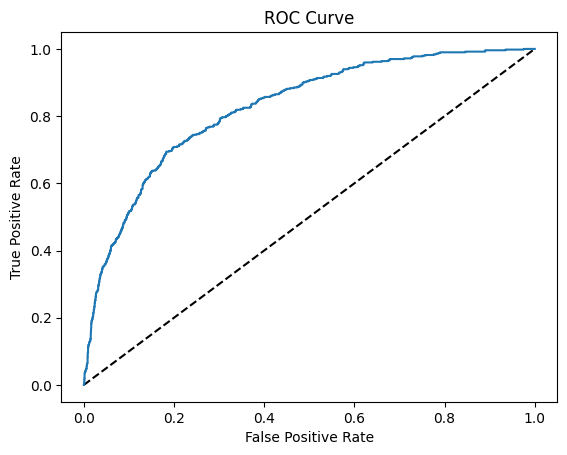

In [144]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [145]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [146]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [147]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)